# Initialize

## Import libraries and set directories

In [99]:
import numpy as np
import os
import pandas as pd
from arcpy import env                     #for dbf conversion
from arcpy import TableToTable_conversion #for dbf conversion
from IPython.display import display, Markdown
from pandas.io.formats.style import Styler
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [100]:
dirWork = os.getcwd()
dirData = os.path.join(dirWork, r'data')
dirLookups = os.path.join(dirWork, r'lookups')
dirOBS = os.path.join(dirData, r'from-2019-obs')
dirTDM = os.path.join(dirData, r'from-2019-tdm')
dirHHS = os.path.join(dirData, r'from-2012-hhs')

print("Working Directory: " + dirWork)
print("Data Directory: " + dirData)
print("Lookups Directory: " + dirLookups)
print("OBS Directory: " + dirOBS)
print("TDM Directory: " + dirTDM)
print("HHS Directory: " + dirHHS)

Working Directory: E:\GitHub\TDM-Validate-ModeShare-Boardings
Data Directory: E:\GitHub\TDM-Validate-ModeShare-Boardings\data
Lookups Directory: E:\GitHub\TDM-Validate-ModeShare-Boardings\lookups
OBS Directory: E:\GitHub\TDM-Validate-ModeShare-Boardings\data\from-2019-obs
TDM Directory: E:\GitHub\TDM-Validate-ModeShare-Boardings\data\from-2019-tdm
HHS Directory: E:\GitHub\TDM-Validate-ModeShare-Boardings\data\from-2012-hhs


In [101]:
nameTripsObs    = 'Trips-Observed'
nameTripsMod    = 'Trips-Model'
nameShareObs    = 'Share-Observed'
nameShareMod    = 'Share-Model'
nameShareDiff   = 'Share Diff'
nameBoardObs    = 'Boardings-Observed'
nameBoardMod    = 'Boardings-Model'
nameTxRatioObs  = 'Transfer Ratio-Observed'
nameTxRatioMod  = 'Transfer Ratio-Model'

# MODE SHARE

## On-Board Survey (OBS) Shares

### Open OBS CSV

In [102]:
csv_OBS = os.path.join(dirOBS, r'2019 Final Weighted UTA OD Data - 2020-09-09_BH.csv')

df_OBS  = pd.read_csv(csv_OBS)

#Use only use = 1
df_OBS = df_OBS[df_OBS.Use == 1]

#filter out HBSch trips  --DON'T FILTER THESE OUT
#df_OBS = df_OBS[df_OBS.Purp5_text != 'HBSch']

# Show column names 
#for column in list(df_OBS.columns):
#    print(column)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (28,29,31,32,45,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [103]:
#define column names for grouping

colIdOBS        = 'id'
colPurpOBS      = 'Purp5_text'      #trip purpose
colPeriodOBS    = 'PK_OK'           #period
colVOwnOBS      = 'Veh_Cat3p'       #number of vehicles
colModeAcOBS    = 'Ac_Mode_Model'   #access mode
colModeTrOBS    = 'Linked_Mode_txt' #transit mode (highest in heirarchy)
colModeBoardOBS = 'Surveyed_Mode'   #boarding mode (surveyed mode)
colTripsOBS     = 'linked_weight'   #trip weight
colBoardOBS     = 'unlinked_weight' #boarding weight

nameIdOBS       = "ID_OBS"
namePurp        = "Trip Purpose"
namePeriod      = "Period"
nameVOwn        = "Vehicle Ownership"
nameModeAccess  = "Access Mode"
nameModeTransit = "Transit Mode"
nameModeBoard   = "Transit Mode - Surveyed"

nameTripsOBS     = "Trips_OBS"
nameBoardOBS     = "Boardings_OBS"
nameShareOBS     = "Share_OBS"
nameRecordsOBS   = "Records_OBS"

In [104]:
df_OBS

,id,date_completed,final_route_surveyed_code,final_route_surveyed,direction,mode,purpose,resident_or_visitor_code,home_or_hotel_address,home_or_hotel_city,...,SecndMode,ThirdMode,LastMode,Surveyed_Mode,AcMode_TrMode,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246
0,22.0,9-Sep-19,SLC_1_704_00,TRAX GREEN LINE TO WEST VALLEY CENTRAL STATION,0.0,1.0,1.0,1.0,5458 Jeremiah Dr,Kearns,...,LCL,LCL,LCL,LRT,Walk_LRT,NaN,NaN,NaN,NaN,NaN
1,24.0,9-Sep-19,SLC_1_704_00,TRAX GREEN LINE TO WEST VALLEY CENTRAL STATION,0.0,1.0,4.0,2.0,265 E 8880 S,Sandy,...,na,na,LRT,LRT,Walk_LRT,NaN,NaN,NaN,NaN,NaN
2,29.0,9-Sep-19,SLC_1_704_00,TRAX GREEN LINE TO WEST VALLEY CENTRAL STATION,0.0,1.0,3.0,1.0,644 W North Temple St,Salt Lake City,...,LCL,na,LCL,LRT,Walk_LRT,NaN,NaN,NaN,NaN,NaN
3,30.0,9-Sep-19,SLC_1_703_00,TRAX RED LINE TO DAYBREAK PARKWAY STATION,0.0,1.0,2.0,1.0,262 E Whitlock Ave,South Salt Lake,...,CRT,na,CRT,LRT,Drive_CRT,NaN,NaN,NaN,NaN,NaN
4,31.0,9-Sep-19,SLC_1_704_01,TRAX GREEN LINE TO AIRPORT STATION,1.0,1.0,1.0,1.0,2900 Lehman Ave,West Valley City,...,na,na,LRT,LRT,Walk_LRT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13412,22742.0,11-Dec-19,SLC_1_704_00,TRAX GREEN LINE TO WEST VALLEY CENTRAL STATION,0.0,1.0,1.0,1.0,2814 W Lemay Ave,West Valley City,...,na,na,LRT,LRT,Walk_LRT,NaN,NaN,NaN,NaN,NaN
13413,22743.0,11-Dec-19,SLC_1_704_01,TRAX GREEN LINE TO AIRPORT STATION,1.0,1.0,1.0,1.0,1420 W Arapahoe Ave,Salt Lake City,...,LCL,na,LCL,LRT,Walk_LRT,NaN,NaN,NaN,NaN,NaN
13414,22744.0,11-Dec-19,SLC_1_750_00,FRONTRUNNER TO OGDEN STATION,0.0,2.0,1.0,1.0,W 4800 S,Roy,...,na,na,CRT,CRT,Drive_CRT,NaN,NaN,NaN,NaN,NaN
13415,22745.0,11-Dec-19,SLC_1_750_00,FRONTRUNNER TO OGDEN STATION,0.0,2.0,1.0,1.0,2150 W 4800 S,Roy,...,CRT,na,CRT,CRT,Walk_CRT,NaN,NaN,NaN,NaN,NaN


In [105]:
#create dataset with only desired columns
df_OBS = df_OBS[[colIdOBS,colVOwnOBS,colPurpOBS,colModeAcOBS,colModeTrOBS,colModeBoardOBS,colPeriodOBS,colTripsOBS,colBoardOBS]]

df_OBS.columns = (nameIdOBS,nameVOwn,namePurp,nameModeAccess,nameModeTransit,nameModeBoard,namePeriod,nameTripsOBS,nameBoardOBS)

#check column names
df_OBS.columns

Index(['ID_OBS', 'Vehicle Ownership', 'Trip Purpose', 'Access Mode',
       'Transit Mode', 'Transit Mode - Surveyed', 'Period', 'Trips_OBS',
       'Boardings_OBS'],
      dtype='object')

In [106]:
# storing dtype before converting 
before = df_OBS[nameVOwn].dtypes 
  
# converting dtypes using astype 
df_OBS[nameVOwn]= df_OBS[nameVOwn].astype(str) 
  
# storing dtype after converting 
after = df_OBS[nameVOwn].dtypes 
  
# printing to compare 
print("BEFORE CONVERSION\n", before, "\n") 
print("AFTER CONVERSION\n", after, "\n") 

BEFORE CONVERSION
 float64 

AFTER CONVERSION
 object 



C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### OBS Transit Share Tables

In [107]:
#filters use '$' for all

#global filters
filterPurp = '$';     # Options: $-all, HBC, HBO, HBW, NHB
filterVOwn = '$';     # Options: $-all, 1, 2, 3
filterPeriod = '$';    # Options: $-all, PK-peak, OK-Off-peak
groupbyFields = [namePeriod]; # Options: ''-none or a combination of namePurp, nameVOwn, namePeriod

#group definition arrays
aFilterModeAc = []
aShareFields = []

#MAIN GROUPINGS
#transit mode
aFilterModeAc.append('$')
aShareFields.append(nameModeTransit)

#access mode
aFilterModeAc.append('$')
aShareFields.append(nameModeAccess)

#walk-access mode
aFilterModeAc.append('Walk')
aShareFields.append(nameModeTransit)

#drive-access mode
aFilterModeAc.append('Drive')
aShareFields.append(nameModeTransit)

#apply filters
df_OBSf = df_OBS
df_OBSf = df_OBSf.loc[(df_OBSf[namePurp].str.contains(filterPurp))]
df_OBSf = df_OBSf.loc[(df_OBSf[nameVOwn].str.contains(filterVOwn))]
df_OBSf = df_OBSf.loc[(df_OBSf[namePeriod].str.contains(filterPeriod))]

#Add dummy column for grouping if no grouping defined
strNoGrp = 'NoGroups'
if (groupbyFields == ['']):
    df_OBSf[strNoGrp] = strNoGrp
    groupbyFields = [strNoGrp]

strTotalField = ""
strTotal = "z--Total--z"
    
#Display filter information
print('\n')
display(Markdown('## OBS Transit Shares'))

#initialize dataframe collections
df_OBSfs = []
df_OBSfs_grp = []
df_OBSfs_grp_joined = []

#loop through main groupings
for x in range(len(aFilterModeAc)):

    #apply Access Mode filter
    df_OBSfx = df_OBSf.loc[(df_OBSf[nameModeAccess].str.contains(aFilterModeAc[x]))].copy()
    
    #add filtered dataset to collection
    df_OBSfs.append(df_OBSfx)
    
    #aggregate by groupbyFields
    df_OBSfx_grp = df_OBSfx.groupby(groupbyFields, as_index=False).agg({nameTripsOBS: [np.size, np.sum]})

    #collapse column names from multi-index
    df_OBSfx_grp.columns = df_OBSfx_grp.columns.map(''.join)

    #rename columns
    df_OBSfx_grp = df_OBSfx_grp.rename(columns={nameTripsOBS+'sum':"g"+nameTripsOBS,nameTripsOBS+'size':"g"+nameRecordsOBS})
    
    #add grouped dataset to collection
    df_OBSfs_grp.append(df_OBSfx_grp)

    #create new grouping by making copy and adding access
    shareFields = groupbyFields.copy()
    shareFields.append(aShareFields[x])

    #aggregate by shareFields
    df_OBSfx_grp_share = df_OBSfx.groupby(shareFields, as_index=False).agg({nameTripsOBS: [np.size, np.sum]})

    #collapse column names
    df_OBSfx_grp_share.columns = df_OBSfx_grp_share.columns.map(''.join)

    #rename columns
    df_OBSfx_grp_share = df_OBSfx_grp_share.rename(columns={nameTripsOBS+'sum':nameTripsOBS,nameTripsOBS+'size':nameRecordsOBS})

    #join share data back to grouped data
    df_OBSfx_grp_joined = pd.DataFrame.merge(df_OBSfx_grp_share, df_OBSfx_grp, on=groupbyFields)

    #calcuate shares
    df_OBSfx_grp_joined[nameShareOBS] = df_OBSfx_grp_joined[nameTripsOBS] / df_OBSfx_grp_joined["g"+nameTripsOBS]
    df_OBSfx_grp_joined = df_OBSfx_grp_joined.drop(columns=["g"+nameTripsOBS,"g"+nameRecordsOBS])

    #add to collection df_OBSfs_grp_joined
    df_OBSfs_grp_joined.append(df_OBSfx_grp_joined)
    
    #calculate total
    #df_OBSfx_grp_joined = df_OBSfx_grp_joined.append(df_OBSfx_grp_joined.sum(numeric_only=True).rename('Total'))

    #calculate group subtotals
    df_OBSfx_grp_joined_totals = df_OBSfx_grp_joined.groupby(groupbyFields, as_index=False).agg({nameRecordsOBS:[np.sum],nameTripsOBS:[np.sum],nameShareOBS:[np.sum]})

    #add column with z--Total--z descripion, uses z so it always sorts last
    df_OBSfx_grp_joined_totals[aShareFields[x]] = strTotal

    #drop the second level "sum" of multi-index
    df_OBSfx_grp_joined_totals.columns = df_OBSfx_grp_joined_totals.columns.droplevel(1)
    
    #append totals to joined dataset
    df_OBSfx_grp_joined_withtotals = df_OBSfx_grp_joined.append(df_OBSfx_grp_joined_totals,ignore_index=True)
    
    #redo sort so totals are sorted with gruoped data
    df_OBSfx_grp_joined_withtotals = df_OBSfx_grp_joined_withtotals.sort_values(by=shareFields)
 
    #display Table Title and access mode filter
    if (groupbyFields != [strNoGrp]):
        strTitleBy = " by " + ', '.join(groupbyFields).replace(strNoGrp,"")
    else:
        strTitleBy = ""
        df_OBSfx_grp_joined_withtotals = df_OBSfx_grp_joined_withtotals.drop(columns=strNoGrp)
    
    display (Markdown('***'))
    display (Markdown('### ' + aShareFields[x] + " Shares" + strTitleBy))
    if (aFilterModeAc[x] != "$"):
        display (Markdown('#### Access Mode: ' + aFilterModeAc[x].replace("$","All")))

    display(Markdown("Purpose: " + filterPurp.replace("$","All") + "; Vehicle Ownership: " + filterVOwn.replace("$","All") + "; Period: " + filterPeriod.replace("$","All")))

    def highlight(s):        
        if s[aShareFields[x]] == strTotal:
            return ['background-color: grey; color: white']*len(s)
        else:
            return ['']*len(s)

    #print dataframe
    display(df_OBSfx_grp_joined_withtotals
            .style
            .format({nameRecordsOBS: "{:,.0f}".format, nameTripsOBS:"{:,.0f}".format, nameShareOBS: "{:,.1%}".format})
            .apply(highlight, axis=1)
            )

## OBS Transit Shares

***

### Transit Mode Shares by Period

Purpose: All; Vehicle Ownership: All; Period: All

,Period,Transit Mode,Records_OBS,Trips_OBS,Share_OBS
0,OK,BRT1,47,385,0.8%
1,OK,BRT3,254,"4,857",9.7%
2,OK,CRT,"1,430","6,463",12.9%
3,OK,EXP,13,98,0.2%
4,OK,LCL,"1,745","18,316",36.5%
5,OK,LRT,"3,353","20,050",40.0%
12,OK,z--Total--z,"6,842","50,169",100.0%
6,PK,BRT1,48,401,0.7%
7,PK,BRT3,252,"4,558",7.7%
8,PK,CRT,"1,477","12,039",20.5%


***

### Access Mode Shares by Period

Purpose: All; Vehicle Ownership: All; Period: All

,Period,Access Mode,Records_OBS,Trips_OBS,Share_OBS
0,OK,Drive,"1,800","9,544",19.0%
1,OK,Walk,"5,042","40,625",81.0%
4,OK,z--Total--z,"6,842","50,169",100.0%
2,PK,Drive,"2,083","19,326",32.9%
3,PK,Walk,"4,326","39,505",67.1%
5,PK,z--Total--z,"6,409","58,831",100.0%


***

### Transit Mode Shares by Period

#### Access Mode: Walk

Purpose: All; Vehicle Ownership: All; Period: All

,Period,Transit Mode,Records_OBS,Trips_OBS,Share_OBS
0,OK,BRT1,46,376,0.9%
1,OK,BRT3,227,"4,409",10.9%
2,OK,CRT,533,"2,158",5.3%
3,OK,EXP,3,20,0.0%
4,OK,LCL,"1,652","17,280",42.5%
5,OK,LRT,"2,581","16,383",40.3%
12,OK,z--Total--z,"5,042","40,625",100.0%
6,PK,BRT1,44,383,1.0%
7,PK,BRT3,217,"3,800",9.6%
8,PK,CRT,434,"2,898",7.3%


***

### Transit Mode Shares by Period

#### Access Mode: Drive

Purpose: All; Vehicle Ownership: All; Period: All

,Period,Transit Mode,Records_OBS,Trips_OBS,Share_OBS
0,OK,BRT1,1,9,0.1%
1,OK,BRT3,27,448,4.7%
2,OK,CRT,897,"4,305",45.1%
3,OK,EXP,10,78,0.8%
4,OK,LCL,93,"1,037",10.9%
5,OK,LRT,772,"3,667",38.4%
12,OK,z--Total--z,"1,800","9,544",100.0%
6,PK,BRT1,4,17,0.1%
7,PK,BRT3,35,758,3.9%
8,PK,CRT,"1,043","9,141",47.3%


## Household Survey (HHS) Shares

In [108]:
csv_HHS = os.path.join(dirHHS, r'TripData_June19_2013.csv')

df_HHS  = pd.read_csv(csv_HHS)

#Use only internal-to-internal trips
df_HHS = df_HHS[df_HHS.WF_IXXI_MS == 'II']

#Do not use other trips
df_HHS = df_HHS[df_HHS.main_mode_w_auto_occ_text != 'other']

#Do not use school trips - INCLUDE SCHOOL TRIPS
#df_HHS = df_HHS[df_HHS.trip_purpose_text != 'HBSch']

# Show column names 
#for column in list(df_HHS.columns):
#    print(column)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (15,155) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
#define column names for grouping

colIDHHS     = 'password'
colPurpHHS   = 'trip_purpose_text'          #trip purpose
colPeriodHHS = 'depart_period'              #period
colVOwnHHS   = 'num_vehicles_cat'           #number of vehicles
colModeHHS   = 'main_mode_w_auto_occ_text'  #access mode
colTripsHHS  = 'weight'                     #trip weight

nameIDHHS    = "ID_HHS"
namePurp     = "Trip Purpose"
namePeriod   = "Period"
nameVOwn     = "Vehicle Ownership"
nameMode     = "Mode"
nameTripsHHS = "Trips_HHS"

nameModeMotor       = "Motorized / Non-Motorized"
nameModeBikeWalk    = "Bike / Walk"
nameModeDAShare     = "Drive Alone / Share Ride"
nameModeShare23     = "Share 2 / Share 3+"
nameModeAutoTransit = "Auto / Transit"

nameShareHHS = "Share_HHS"
nameRecordsHHS = "Records_HHS"

In [110]:
#create dataset with only desired columns
df_HHS = df_HHS[[colIDHHS,colPeriodHHS,colPurpHHS,colVOwnHHS,colModeHHS,colTripsHHS]]

df_HHS.columns = (nameIDHHS,namePeriod,namePurp,nameVOwn,nameMode,nameTripsHHS)

#check column names
df_HHS.columns

Index(['ID_HHS', 'Period', 'Trip Purpose', 'Vehicle Ownership', 'Mode',
       'Trips_HHS'],
      dtype='object')

In [111]:
df_HHS

,ID_HHS,Period,Trip Purpose,Vehicle Ownership,Mode,Trips_HHS
0,M20041FA,2,HBW,2,auto_sov,107.017335
1,W39257CD,3,HBW,2,auto_sov,122.041307
2,W53356KH,2,HBW,2,auto_sov,70.894658
3,W39257CD,1,HBW,2,auto_sov,122.041307
4,W48216UM,1,HBW,2,auto_sov,65.858851
...,...,...,...,...,...,...
99303,M23288ES,4,HBW,2,auto_occ3p,74.901198
99304,M23288ES,4,HBW,2,auto_occ3p,74.901198
99305,M23288ES,4,HBW,2,auto_occ3p,74.901198
99306,W16558BU,3,HBW,2,auto_occ2,83.872572


In [112]:
# storing dtype before converting 
before = df_HHS[[namePeriod,nameVOwn]].dtypes
  
# converting dtypes using astype 
df_HHS[namePeriod]= df_HHS[namePeriod].astype(str)
df_HHS[nameVOwn]= df_HHS[nameVOwn].astype(str)
  
# storing dtype after converting 
after = df_HHS[[namePeriod,nameVOwn]].dtypes
  
# printing to compare 
print("BEFORE CONVERSION\n", before, "\n") 
print("AFTER CONVERSION\n", after, "\n") 

BEFORE CONVERSION
 Period               int64
Vehicle Ownership    int64
dtype: object 

AFTER CONVERSION
 Period               object
Vehicle Ownership    object
dtype: object 



In [113]:
#combine Trip Purpose categories to 5 only
df_HHS.loc[(df_HHS[namePurp] == "HBShp") | (df_HHS[namePurp] == "HBO") | (df_HHS[namePurp] == "HBPb"), namePurp] = "HBO"
df_HHS.loc[(df_HHS[namePurp] == "NHBW") | (df_HHS[namePurp] == "NHBNW"), namePurp]  = "NHB"

#change period to PK/OK to be able to match to TDM
df_HHS.loc[(df_HHS[namePeriod] == "1") | (df_HHS[namePeriod] == "3"), namePeriod] = "PK"
df_HHS.loc[(df_HHS[namePeriod] == "2") | (df_HHS[namePeriod] == "4"), namePeriod] = "OK"


In [114]:
#Mode group definitions

dHHSModes = {
             nameMode: ['bike'         ,'walk'         ,'auto_sov'   ,'auto_occ2'    ,'auto_occ3p'    ,'transit'  ],
        nameModeMotor: ['Non-Motorized','Non-Motorized','Motorized'  ,'Motorized'    ,'Motorized'     ,'Motorized'],
     nameModeBikeWalk: ['Bike'         ,'Walk'         ,''           ,''             ,''              ,''         ],
      nameModeDAShare: [''             ,''             ,'Drive Alone','Share Ride'   ,'Share Ride'    ,''         ],
      nameModeShare23: [''             ,''             ,''           ,'Shared Ride 2','Shared Ride 3+',''         ],
  nameModeAutoTransit: [''             ,''             ,'Auto'       ,'Auto'         ,'Auto'          ,'Transit'  ]
}
df_HHSModes = pd.DataFrame(data=dHHSModes)
df_HHSModes

,Mode,Motorized / Non-Motorized,Bike / Walk,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit
0,bike,Non-Motorized,Bike,,,
1,walk,Non-Motorized,Walk,,,
2,auto_sov,Motorized,,Drive Alone,,Auto
3,auto_occ2,Motorized,,Share Ride,Shared Ride 2,Auto
4,auto_occ3p,Motorized,,Share Ride,Shared Ride 3+,Auto
5,transit,Motorized,,,,Transit


In [115]:
df_HHS = pd.DataFrame.merge(df_HHS, df_HHSModes, on=nameMode, how="left")
df_HHS


,ID_HHS,Period,Trip Purpose,Vehicle Ownership,Mode,Trips_HHS,Motorized / Non-Motorized,Bike / Walk,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit
0,M20041FA,OK,HBW,2,auto_sov,107.017335,Motorized,,Drive Alone,,Auto
1,W39257CD,PK,HBW,2,auto_sov,122.041307,Motorized,,Drive Alone,,Auto
2,W53356KH,OK,HBW,2,auto_sov,70.894658,Motorized,,Drive Alone,,Auto
3,W39257CD,PK,HBW,2,auto_sov,122.041307,Motorized,,Drive Alone,,Auto
4,W48216UM,PK,HBW,2,auto_sov,65.858851,Motorized,,Drive Alone,,Auto
...,...,...,...,...,...,...,...,...,...,...,...
59520,M23288ES,OK,HBW,2,auto_occ3p,74.901198,Motorized,,Share Ride,Shared Ride 3+,Auto
59521,M23288ES,OK,HBW,2,auto_occ3p,74.901198,Motorized,,Share Ride,Shared Ride 3+,Auto
59522,M23288ES,OK,HBW,2,auto_occ3p,74.901198,Motorized,,Share Ride,Shared Ride 3+,Auto
59523,W16558BU,PK,HBW,2,auto_occ2,83.872572,Motorized,,Share Ride,Shared Ride 2,Auto


In [116]:
#filters use '$' for all

#global filters
filterPurp = 'HBW';     # Options: $-all, HBC, HBO, HBW, NHB
filterVOwn = '$';     # Options: $-all, 1, 2, 3
filterPeriod = '$';   # Options: $-all, PK-peak, OK-Off-peak
groupbyFields = [namePurp,namePeriod] # Options: ''-none or a combination of namePurp, nameVOwn, namePeriod

#group definition arrays
aShareFields = []

#MAIN GROUPINGS
#Motorized / Non-Motorized
aShareFields.append(nameModeMotor)

#Walk / Bike
aShareFields.append(nameModeBikeWalk)

#Drive Alone / Shared Ride
aShareFields.append(nameModeDAShare)

#Shared Ride 2 / Shared Ride 3+
aShareFields.append(nameModeShare23)

#Shared Ride 2 / Shared Ride 3+
aShareFields.append(nameModeAutoTransit)   

#apply filters
df_HHSf = df_HHS
df_HHSf = df_HHSf.loc[(df_HHSf[namePurp].str.contains(filterPurp))]
df_HHSf = df_HHSf.loc[(df_HHSf[nameVOwn].str.contains(filterVOwn))]
df_HHSf = df_HHSf.loc[(df_HHSf[namePeriod].str.contains(filterPeriod))]

#Add dummy column for grouping if no grouping defined
strNoGrp = 'NoGroups'
if (groupbyFields == ['']):
    df_HHSf[strNoGrp] = strNoGrp
    groupbyFields = [strNoGrp]

strTotalField = ""
strTotal = "z--Total--z"
    
#Display filter information
print('\n')
display(Markdown('## HHS Transit Shares'))

#initialize dataframe collections
df_HHSfs = []
df_HHSfs_grp = []
df_HHSfs_grp_joined = []

#loop through main groupings
for x in range(len(aShareFields)):

    #filter out empty strings
    df_HHSfx = df_HHSf[df_HHSf[aShareFields[x]] != ''].copy()
    
    #add filtered dataset to collection
    df_HHSfs.append(df_HHSfx)
    
    #aggregate by groupbyFields
    df_HHSfx_grp = df_HHSfx.groupby(groupbyFields, as_index=False).agg({nameTripsHHS: [np.size, np.sum]})

    #collapse column names from multi-index
    df_HHSfx_grp.columns = df_HHSfx_grp.columns.map(''.join)

    #rename columns
    df_HHSfx_grp = df_HHSfx_grp.rename(columns={nameTripsHHS+'sum':"g"+nameTripsHHS,nameTripsHHS+'size':"g"+nameRecordsHHS})
    
    #add grouped dataset to collection
    df_HHSfs_grp.append(df_HHSfx_grp)

    #create new grouping by making copy and adding access
    shareFields = groupbyFields.copy()
    shareFields.append(aShareFields[x])

    #aggregate by shareFields
    df_HHSfx_grp_share = df_HHSfx.groupby(shareFields, as_index=False).agg({nameTripsHHS: [np.size, np.sum]})

    #collapse column names
    df_HHSfx_grp_share.columns = df_HHSfx_grp_share.columns.map(''.join)

    #rename columns
    df_HHSfx_grp_share = df_HHSfx_grp_share.rename(columns={nameTripsHHS+'sum':nameTripsHHS,nameTripsHHS+'size':nameRecordsHHS})

    #join share data back to grouped data
    df_HHSfx_grp_joined = pd.DataFrame.merge(df_HHSfx_grp_share, df_HHSfx_grp, on=groupbyFields)

    #calcuate shares
    df_HHSfx_grp_joined[nameShareHHS] = df_HHSfx_grp_joined[nameTripsHHS] / df_HHSfx_grp_joined["g"+nameTripsHHS]
    df_HHSfx_grp_joined = df_HHSfx_grp_joined.drop(columns=["g"+nameTripsHHS,"g"+nameRecordsHHS])

    #add to collection df_HHSfs_grp_joined
    df_HHSfs_grp_joined.append(df_HHSfx_grp_joined)
    
    #calculate total
    #df_HHSfx_grp_joined = df_HHSfx_grp_joined.append(df_HHSfx_grp_joined.sum(numeric_only=True).rename('Total'))

    #calculate group subtotals
    df_HHSfx_grp_joined_totals = df_HHSfx_grp_joined.groupby(groupbyFields, as_index=False).agg({nameRecordsHHS:[np.sum],nameTripsHHS:[np.sum],nameShareHHS:[np.sum]})

    #add column with z--Total--z descripion, uses z so it always sorts last
    df_HHSfx_grp_joined_totals[aShareFields[x]] = strTotal

    #drop the second level "sum" of multi-index
    df_HHSfx_grp_joined_totals.columns = df_HHSfx_grp_joined_totals.columns.droplevel(1)
    
    #append totals to joined dataset
    df_HHSfx_grp_joined_withtotals = df_HHSfx_grp_joined.append(df_HHSfx_grp_joined_totals,ignore_index=True)
    
    #redo sort so totals are sorted with gruoped data
    df_HHSfx_grp_joined_withtotals = df_HHSfx_grp_joined_withtotals.sort_values(by=shareFields)
 
    #display Table Title and access mode filter
    if (groupbyFields != [strNoGrp]):
        strTitleBy = " by " + ', '.join(groupbyFields).replace(strNoGrp,"")
    else:
        strTitleBy = ""
        df_HHSfx_grp_joined_withtotals = df_HHSfx_grp_joined_withtotals.drop(columns=strNoGrp)
    
    display (Markdown('***'))
    display (Markdown('### ' + aShareFields[x] + " Shares" + strTitleBy))

    display(Markdown("Purpose: " + filterPurp.replace("$","All") + "; Vehicle Ownership: " + filterVOwn.replace("$","All") + "; Period: " + filterPeriod.replace("$","All")))

    def highlight(s):        
        if s[aShareFields[x]] == strTotal:
            return ['background-color: grey; color: white']*len(s)
        else:
            return ['']*len(s)

    #print dataframe
    display(df_HHSfx_grp_joined_withtotals
            .style
            .format({nameRecordsHHS: "{:,.0f}".format, nameTripsHHS:"{:,.0f}".format, nameShareHHS: "{:,.1%}".format})
            .apply(highlight, axis=1)
            )

## HHS Transit Shares

***

### Motorized / Non-Motorized Shares by Trip Purpose, Period

Purpose: HBW; Vehicle Ownership: All; Period: All

,Trip Purpose,Period,Motorized / Non-Motorized,Records_HHS,Trips_HHS,Share_HHS
0,HBW,OK,Motorized,"3,492","409,238",94.5%
1,HBW,OK,Non-Motorized,172,"23,996",5.5%
4,HBW,OK,z--Total--z,"3,664","433,234",100.0%
2,HBW,PK,Motorized,"6,512","732,741",95.9%
3,HBW,PK,Non-Motorized,253,"31,269",4.1%
5,HBW,PK,z--Total--z,"6,765","764,010",100.0%


***

### Bike / Walk Shares by Trip Purpose, Period

Purpose: HBW; Vehicle Ownership: All; Period: All

,Trip Purpose,Period,Bike / Walk,Records_HHS,Trips_HHS,Share_HHS
0,HBW,OK,Bike,62,"7,863",32.8%
1,HBW,OK,Walk,110,"16,133",67.2%
4,HBW,OK,z--Total--z,172,"23,996",100.0%
2,HBW,PK,Bike,125,"13,388",42.8%
3,HBW,PK,Walk,128,"17,881",57.2%
5,HBW,PK,z--Total--z,253,"31,269",100.0%


***

### Drive Alone / Share Ride Shares by Trip Purpose, Period

Purpose: HBW; Vehicle Ownership: All; Period: All

,Trip Purpose,Period,Drive Alone / Share Ride,Records_HHS,Trips_HHS,Share_HHS
0,HBW,OK,Drive Alone,"3,001","343,849",86.7%
1,HBW,OK,Share Ride,399,"52,530",13.3%
4,HBW,OK,z--Total--z,"3,400","396,379",100.0%
2,HBW,PK,Drive Alone,"5,190","568,857",82.0%
3,HBW,PK,Share Ride,"1,004","124,531",18.0%
5,HBW,PK,z--Total--z,"6,194","693,388",100.0%


***

### Share 2 / Share 3+ Shares by Trip Purpose, Period

Purpose: HBW; Vehicle Ownership: All; Period: All

,Trip Purpose,Period,Share 2 / Share 3+,Records_HHS,Trips_HHS,Share_HHS
0,HBW,OK,Shared Ride 2,268,"35,594",67.8%
1,HBW,OK,Shared Ride 3+,131,"16,936",32.2%
4,HBW,OK,z--Total--z,399,"52,530",100.0%
2,HBW,PK,Shared Ride 2,620,"75,843",60.9%
3,HBW,PK,Shared Ride 3+,384,"48,688",39.1%
5,HBW,PK,z--Total--z,"1,004","124,531",100.0%


***

### Auto / Transit Shares by Trip Purpose, Period

Purpose: HBW; Vehicle Ownership: All; Period: All

,Trip Purpose,Period,Auto / Transit,Records_HHS,Trips_HHS,Share_HHS
0,HBW,OK,Auto,"3,400","396,379",96.9%
1,HBW,OK,Transit,92,"12,859",3.1%
4,HBW,OK,z--Total--z,"3,492","409,238",100.0%
2,HBW,PK,Auto,"6,194","693,388",94.6%
3,HBW,PK,Transit,318,"39,353",5.4%
5,HBW,PK,z--Total--z,"6,512","732,741",100.0%


## TDM Shares

In [117]:
nameTripsTDM = 'Trips_TDM'
nameShareTDM = 'Share_TDM'
nameBoardTDM = "Boardings_TDM"

In [118]:
#open TDM CSVs and Combine

csv_TDM_Pk = os.path.join(dirTDM, r'v832_SE19_Net19_RegionShares_Pk.csv')
csv_TDM_Ok = os.path.join(dirTDM, r'v832_SE19_Net19_RegionShares_Ok.csv')

df_TDM_Pk  = pd.read_csv(csv_TDM_Pk)
df_TDM_Ok  = pd.read_csv(csv_TDM_Ok)

df_TDM_Pk['Period'] = 'PK'
df_TDM_Ok['Period'] = 'OK'

df_TDM_base = df_TDM_Pk.append(df_TDM_Ok)

df_TDM_base = df_TDM_base[['Period','TripCategory','HBCtrip','HBOtrip','HBWtrip','NHBtrip']]

# Show column names 
for column in list(df_TDM_base.columns):
    print(column)

Period
TripCategory
HBCtrip
HBOtrip
HBWtrip
NHBtrip


In [119]:
df_TDM = pd.melt(df_TDM_base, id_vars=['Period','TripCategory'], value_vars=['HBCtrip','HBOtrip','HBWtrip','NHBtrip'])
df_TDM.columns = (namePeriod,'TripCategory',namePurp,'Trips_TDM')
df_TDM

,Period,TripCategory,Trip Purpose,Trips_TDM
0,PK,1) Total Trips,HBCtrip,127511
1,PK,2) Non-Motorized,HBCtrip,22089
2,PK,2) Motorized,HBCtrip,105423
3,PK,3) Auto,HBCtrip,86345
4,PK,4) Auto 1 pers,HBCtrip,64164
...,...,...,...,...
419,OK,Network infrastructure year modeled: 2019,NHBtrip,NaN
420,OK,Period the results apply to: Off-Peak Period,NHBtrip,NaN
421,OK,Shares\v832_SE19_Net19_RegionShares_Ok.csv,NHBtrip,NaN
422,OK,For this run Mode Choice was run in its reg...,NHBtrip,NaN


In [120]:
df_TDM = df_TDM[df_TDM['TripCategory'].str.contains("Drive|Walk|Non-Motorized|pers|Transit")]
df_TDM = df_TDM[df_TDM['TripCategory'].str.contains('Drive Self') == False]
df_TDM[namePurp] = df_TDM[namePurp].str.replace("trip","")

#trim white space
df_TDM = df_TDM.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df_TDM.head()

,Period,TripCategory,Trip Purpose,Trips_TDM
1,PK,2) Non-Motorized,HBC,22089
4,PK,4) Auto 1 pers,HBC,64164
7,PK,4) Auto 2 pers,HBC,14451
11,PK,4) Auto 3+pers,HBC,7730
27,PK,3) Transit,HBC,19078


In [121]:
# storing dtype before converting 
before = df_TDM[nameTripsTDM].dtypes 
  
# converting dtypes using astype 
df_TDM[nameTripsTDM]= df_TDM[nameTripsTDM].astype(int) 
  
# storing dtype after converting 
after = df_TDM[nameTripsTDM].dtypes 
  
# printing to compare 
print("BEFORE CONVERSION\n", before, "\n") 
print("AFTER CONVERSION\n", after, "\n") 

BEFORE CONVERSION
 object 

AFTER CONVERSION
 int32 



In [122]:
dTDMCatToModes = {
       'TripCategory': ['2) Non-Motorized','4) Auto 1 pers','4) Auto 2 pers','4) Auto 3+pers','3) Transit','LCL Walk','LCL Drive','BRT Walk','BRT Drive','MODE9 Walk','MODE9 Drive','EXP Walk','EXP Drive','LRT Walk','LRT Drive','CRT Walk','CRT Drive'],
             nameMode: ['bike/walk'       ,'auto_sov'      ,'auto_occ2'     ,'auto_occ3p'    ,'transit'   ,''        ,''         ,''        ,''         ,''          ,''           ,''        ,''         ,''        ,''         ,''        ,''         ],
        nameModeMotor: ['Non-Motorized'   ,'Motorized'     ,'Motorized'     ,'Motorized'     ,'Motorized' ,''        ,''         ,''        ,''         ,''          ,''           ,''        ,''         ,''        ,''         ,''        ,''         ],
     nameModeBikeWalk: [''                ,''              ,''              ,''              ,''          ,''        ,''         ,''        ,''         ,''          ,''           ,''        ,''         ,''        ,''         ,''        ,''         ],
      nameModeDAShare: [''                ,'Drive Alone'   ,'Share Ride'    ,'Share Ride'    ,''          ,''        ,''         ,''        ,''         ,''          ,''           ,''        ,''         ,''        ,''         ,''        ,''         ],
      nameModeShare23: [''                ,''              ,'Shared Ride 2' ,'Shared Ride 3+',''          ,''        ,''         ,''        ,''         ,''          ,''           ,''        ,''         ,''        ,''         ,''        ,''         ],
  nameModeAutoTransit: [''                ,'Auto'          ,'Auto'          ,'Auto'          ,'Transit'   ,''        ,''         ,''        ,''         ,''          ,''           ,''        ,''         ,''        ,''         ,''        ,''         ],
      nameModeTransit: [''                ,''              ,''              ,''              ,''          ,'LCL'     ,'LCL'      ,'BRT1'    ,'BRT1'     ,'BRT3'      ,'BRT3'       ,'EXP'     ,'EXP'      ,'LRT'     ,'LRT'      ,'CRT'     ,'CRT'      ],
       nameModeAccess: [''                ,''              ,''              ,''              ,''          ,'Walk'    ,'Drive'    ,'Walk'    ,'Drive'    ,'Walk'      ,'Drive'      ,'Walk'    ,'Drive'    ,'Walk'    ,'Drive'    ,'Walk'    ,'Drive'    ]
}
df_TDMCatToModes = pd.DataFrame(dTDMCatToModes)
df_TDMCatToModes

,TripCategory,Mode,Motorized / Non-Motorized,Bike / Walk,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit,Transit Mode,Access Mode
0,2) Non-Motorized,bike/walk,Non-Motorized,,,,,,
1,4) Auto 1 pers,auto_sov,Motorized,,Drive Alone,,Auto,,
2,4) Auto 2 pers,auto_occ2,Motorized,,Share Ride,Shared Ride 2,Auto,,
3,4) Auto 3+pers,auto_occ3p,Motorized,,Share Ride,Shared Ride 3+,Auto,,
4,3) Transit,transit,Motorized,,,,Transit,,
5,LCL Walk,,,,,,,LCL,Walk
6,LCL Drive,,,,,,,LCL,Drive
7,BRT Walk,,,,,,,BRT1,Walk
8,BRT Drive,,,,,,,BRT1,Drive
9,MODE9 Walk,,,,,,,BRT3,Walk


In [123]:
df_TDM

,Period,TripCategory,Trip Purpose,Trips_TDM
1,PK,2) Non-Motorized,HBC,22089
4,PK,4) Auto 1 pers,HBC,64164
7,PK,4) Auto 2 pers,HBC,14451
11,PK,4) Auto 3+pers,HBC,7730
27,PK,3) Transit,HBC,19078
29,PK,LCL Walk,HBC,3803
30,PK,LCL Drive,HBC,1582
32,PK,BRT Walk,HBC,15
33,PK,BRT Drive,HBC,11
35,PK,MODE9 Walk,HBC,4425


In [124]:
df_TDM = pd.DataFrame.merge(df_TDM, df_TDMCatToModes, on="TripCategory", how="left")
df_TDM = df_TDM.drop(columns='TripCategory')
df_TDM_PrPuTrAc = df_TDM.copy()
df_TDM_PrPuTrAc = df_TDM_PrPuTrAc.rename(columns={nameTripsTDM: nameTripsMod})
df_TDM_PrPuTrAc

,Period,Trip Purpose,Trips-Model,Mode,Motorized / Non-Motorized,Bike / Walk,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit,Transit Mode,Access Mode
0,PK,HBC,22089,bike/walk,Non-Motorized,,,,,,
1,PK,HBC,64164,auto_sov,Motorized,,Drive Alone,,Auto,,
2,PK,HBC,14451,auto_occ2,Motorized,,Share Ride,Shared Ride 2,Auto,,
3,PK,HBC,7730,auto_occ3p,Motorized,,Share Ride,Shared Ride 3+,Auto,,
4,PK,HBC,19078,transit,Motorized,,,,Transit,,
5,PK,HBC,3803,,,,,,,LCL,Walk
6,PK,HBC,1582,,,,,,,LCL,Drive
7,PK,HBC,15,,,,,,,BRT1,Walk
8,PK,HBC,11,,,,,,,BRT1,Drive
9,PK,HBC,4425,,,,,,,BRT3,Walk


## Compare Observed (OBS/HHS) to Modeled (TDM)

In [125]:
df_OBS_PrPuTrAc = df_OBS.groupby([namePeriod,namePurp,nameModeTransit,nameModeAccess], as_index=False).agg({nameTripsOBS: [np.sum]})

df_OBS_PrPuTrAc.columns = df_OBS_PrPuTrAc.columns.droplevel(1)

df_OBS_PrPuTrAc = df_OBS_PrPuTrAc.rename(columns={nameTripsOBS: nameTripsObs})

df_OBS_PrPuTrAc[nameModeMotor]       =''
df_OBS_PrPuTrAc[nameModeDAShare]     = ''
df_OBS_PrPuTrAc[nameModeShare23]     = ''
df_OBS_PrPuTrAc[nameModeAutoTransit] = ''

df_OBS_PrPuTrAc

,Period,Trip Purpose,Transit Mode,Access Mode,Trips-Observed,Motorized / Non-Motorized,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit
0,OK,HBC,BRT1,Walk,7.23378,,,,
1,OK,HBC,BRT3,Drive,339.18271,,,,
2,OK,HBC,BRT3,Walk,2337.23047,,,,
3,OK,HBC,CRT,Drive,1675.88046,,,,
4,OK,HBC,CRT,Walk,381.71557,,,,
5,OK,HBC,EXP,Walk,13.59891,,,,
6,OK,HBC,LCL,Drive,419.02301,,,,
7,OK,HBC,LCL,Walk,3329.57845,,,,
8,OK,HBC,LRT,Drive,1168.18435,,,,
9,OK,HBC,LRT,Walk,1726.25526,,,,


In [126]:
df_HHS_PrPuTrAc = df_HHS.groupby([namePeriod,namePurp,nameModeMotor,nameModeDAShare,nameModeShare23,nameModeAutoTransit], as_index=False).agg({nameTripsHHS: [np.sum]})  
    
df_HHS_PrPuTrAc.columns = df_HHS_PrPuTrAc.columns.droplevel(1)
            
df_HHS_PrPuTrAc = df_HHS_PrPuTrAc.rename(columns={nameTripsHHS: nameTripsObs})

df_HHS_PrPuTrAc[nameModeTransit] = ''
df_HHS_PrPuTrAc[nameModeAccess]  = ''

df_HHS_PrPuTrAc

,Period,Trip Purpose,Motorized / Non-Motorized,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit,Trips-Observed,Transit Mode,Access Mode
0,OK,HBC,Motorized,,,Transit,6095.339783,,
1,OK,HBC,Motorized,Drive Alone,,Auto,23417.603651,,
2,OK,HBC,Motorized,Share Ride,Shared Ride 2,Auto,4670.891908,,
3,OK,HBC,Motorized,Share Ride,Shared Ride 3+,Auto,2205.967866,,
4,OK,HBC,Non-Motorized,,,,6577.326435,,
5,OK,HBO,Motorized,,,Transit,15645.482723,,
6,OK,HBO,Motorized,Drive Alone,,Auto,698951.137692,,
7,OK,HBO,Motorized,Share Ride,Shared Ride 2,Auto,516385.026106,,
8,OK,HBO,Motorized,Share Ride,Shared Ride 3+,Auto,788915.441024,,
9,OK,HBO,Non-Motorized,,,,253598.956105,,


In [127]:
df_Observed_PrPuTrAc = pd.concat([df_OBS_PrPuTrAc, df_HHS_PrPuTrAc])
df_Observed_PrPuTrAc

,Period,Trip Purpose,Transit Mode,Access Mode,Trips-Observed,Motorized / Non-Motorized,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit
0,OK,HBC,BRT1,Walk,7.233780,,,,
1,OK,HBC,BRT3,Drive,339.182710,,,,
2,OK,HBC,BRT3,Walk,2337.230470,,,,
3,OK,HBC,CRT,Drive,1675.880460,,,,
4,OK,HBC,CRT,Walk,381.715570,,,,
5,OK,HBC,EXP,Walk,13.598910,,,,
6,OK,HBC,LCL,Drive,419.023010,,,,
7,OK,HBC,LCL,Walk,3329.578450,,,,
8,OK,HBC,LRT,Drive,1168.184350,,,,
9,OK,HBC,LRT,Walk,1726.255260,,,,


In [128]:
df_COMP = pd.DataFrame.merge(df_TDM_PrPuTrAc,df_Observed_PrPuTrAc,on=(namePeriod,namePurp,nameModeTransit,nameModeAccess,nameModeMotor,nameModeDAShare,nameModeShare23,nameModeAutoTransit),how="outer")

#show all rows
pd.set_option('display.max_rows', df_COMP.shape[0]+1)


df_COMP

,Period,Trip Purpose,Trips-Model,Mode,Motorized / Non-Motorized,Bike / Walk,Drive Alone / Share Ride,Share 2 / Share 3+,Auto / Transit,Transit Mode,Access Mode,Trips-Observed
0,PK,HBC,22089.0,bike/walk,Non-Motorized,,,,,,,10118.026699
1,PK,HBC,64164.0,auto_sov,Motorized,,Drive Alone,,Auto,,,21459.889184
2,PK,HBC,14451.0,auto_occ2,Motorized,,Share Ride,Shared Ride 2,Auto,,,5407.819473
3,PK,HBC,7730.0,auto_occ3p,Motorized,,Share Ride,Shared Ride 3+,Auto,,,3184.261830
4,PK,HBC,19078.0,transit,Motorized,,,,Transit,,,6712.333170
5,PK,HBC,3803.0,,,,,,,LCL,Walk,2217.518150
6,PK,HBC,1582.0,,,,,,,LCL,Drive,399.582460
7,PK,HBC,15.0,,,,,,,BRT1,Walk,5.476350
8,PK,HBC,11.0,,,,,,,BRT1,Drive,NaN
9,PK,HBC,4425.0,,,,,,,BRT3,Walk,1581.734130


# Model/Observed Transit Shares Comparsion

***

## Motorized / Non-Motorized Shares

Purpose: All; Period: All

,Motorized / Non-Motorized,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,Motorized,"8,158,427","6,153,379",91.6%,91.6%,-0.0%
1,Non-Motorized,"752,956","566,862",8.4%,8.4%,0.0%
2,z--Total--z,"8,911,383","6,720,241",100.0%,100.0%,-0.0%


***

## Auto / Transit Shares

Purpose: All; Period: All

,Auto / Transit,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,Auto,"8,048,666","6,033,085",98.7%,98.0%,0.6%
1,Transit,"109,761","120,294",1.3%,2.0%,-0.6%
2,z--Total--z,"8,158,427","6,153,379",100.0%,100.0%,0.0%


***

## Drive Alone / Share Ride Shares

Purpose: All; Period: All

,Drive Alone / Share Ride,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,Drive Alone,"3,792,265","2,678,388",47.1%,44.4%,2.7%
1,Share Ride,"4,256,401","3,354,697",52.9%,55.6%,-2.7%
2,z--Total--z,"8,048,666","6,033,085",100.0%,100.0%,0.0%


***

## Share 2 / Share 3+ Shares

Purpose: All; Period: All

,Share 2 / Share 3+,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,Shared Ride 2,"1,823,517","1,373,170",42.8%,40.9%,1.9%
1,Shared Ride 3+,"2,432,884","1,981,526",57.2%,59.1%,-1.9%
2,z--Total--z,"4,256,401","3,354,697",100.0%,100.0%,-0.0%


***

## Transit Mode Shares

Purpose: All; Period: All

,Transit Mode,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,BRT1,409,786,0.4%,0.7%,-0.3%
1,BRT3,"9,032","9,415",8.2%,8.6%,-0.4%
2,CRT,"17,265","18,502",15.7%,17.0%,-1.2%
3,EXP,687,696,0.6%,0.6%,-0.0%
4,LCL,"38,488","36,385",35.1%,33.4%,1.7%
5,LRT,"43,795","43,216",39.9%,39.6%,0.3%
6,z--Total--z,"109,676","109,000",100.0%,100.0%,-0.0%


***

## Access Mode Shares

Purpose: All; Period: All

,Access Mode,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,Drive,"25,607","28,870",23.3%,26.5%,-3.1%
1,Walk,"84,069","80,130",76.7%,73.5%,3.1%
2,z--Total--z,"109,676","109,000",100.0%,100.0%,-0.0%


***

## Drive Access: Transit Mode Shares

Purpose: All; Period: All

,Transit Mode,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,BRT1,58,27,0.2%,0.1%,0.1%
1,BRT3,163,"1,206",0.6%,4.2%,-3.5%
2,CRT,"11,821","13,446",46.2%,46.6%,-0.4%
3,EXP,553,574,2.2%,2.0%,0.2%
4,LCL,"3,479","2,663",13.6%,9.2%,4.4%
5,LRT,"9,533","10,953",37.2%,37.9%,-0.7%
6,z--Total--z,"25,607","28,870",100.0%,100.0%,0.0%


***

## Walk Access: Transit Mode Shares

Purpose: All; Period: All

,Transit Mode,Trips-Model,Trips-Observed,Share-Model,Share-Observed,Share Diff
0,BRT1,351,759,0.4%,0.9%,-0.5%
1,BRT3,"8,869","8,209",10.5%,10.2%,0.3%
2,CRT,"5,444","5,056",6.5%,6.3%,0.2%
3,EXP,134,122,0.2%,0.2%,0.0%
4,LCL,"35,009","33,722",41.6%,42.1%,-0.4%
5,LRT,"34,262","32,263",40.8%,40.3%,0.5%
6,z--Total--z,"84,069","80,130",100.0%,100.0%,-0.0%


***

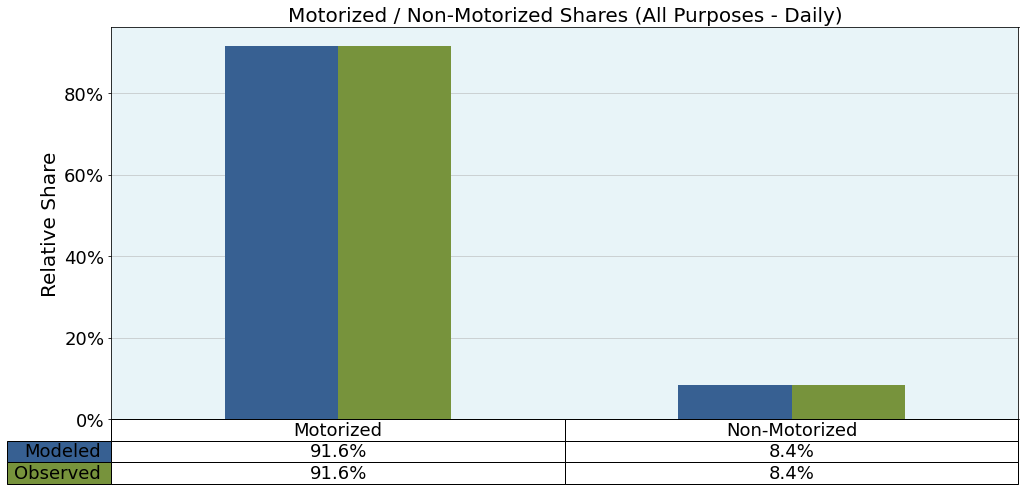

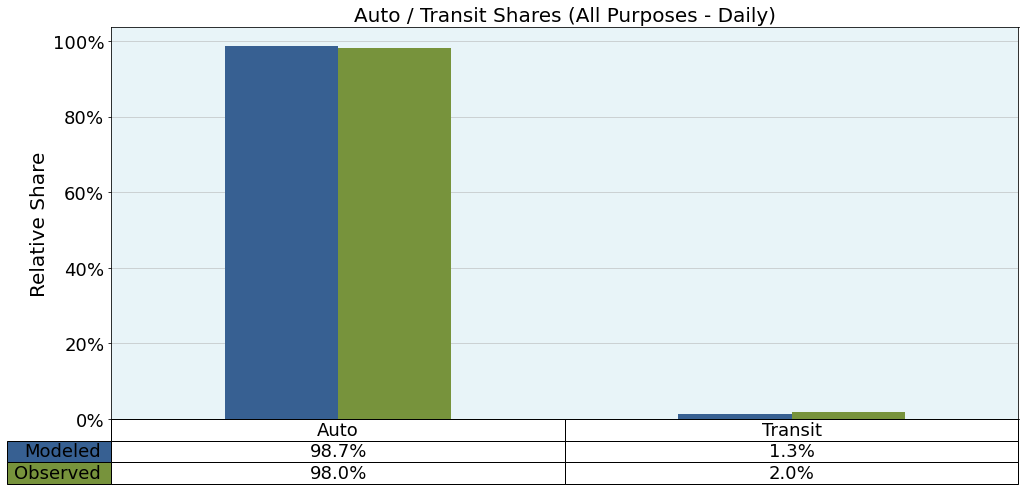

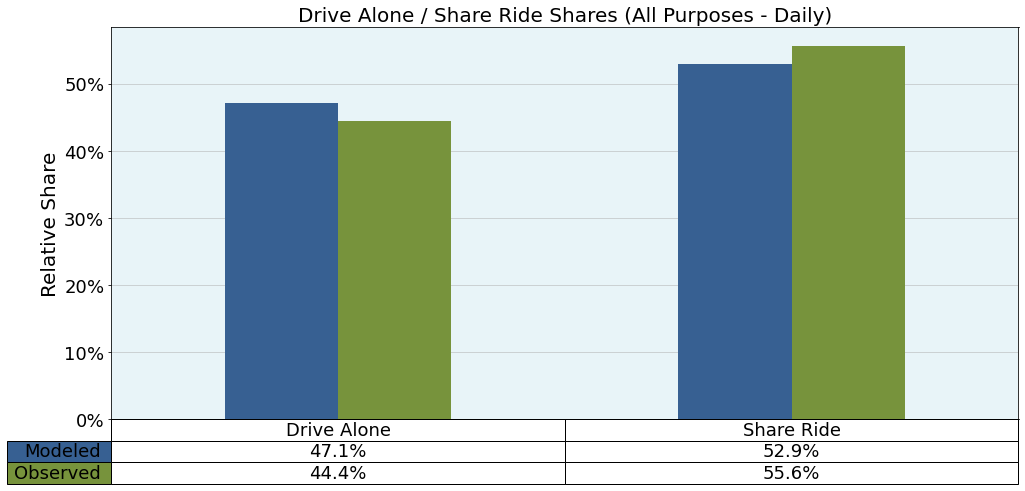

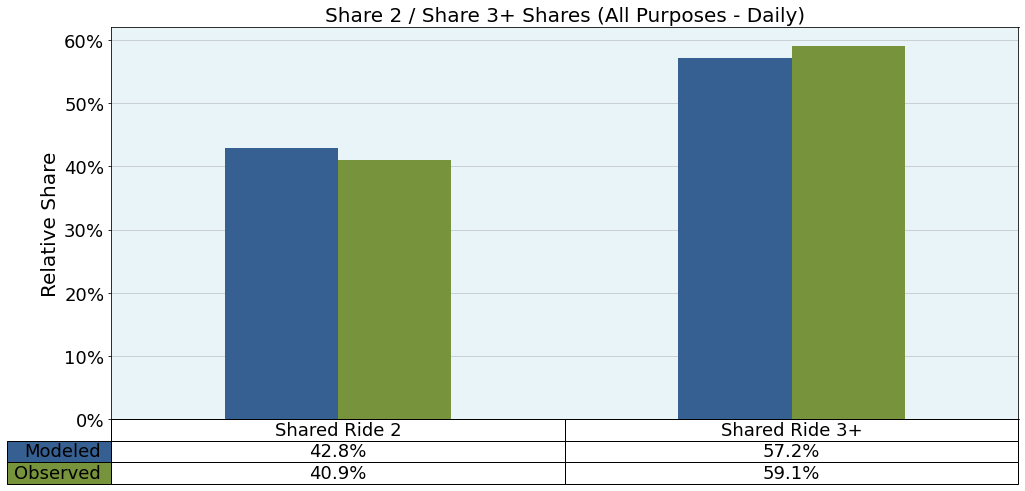

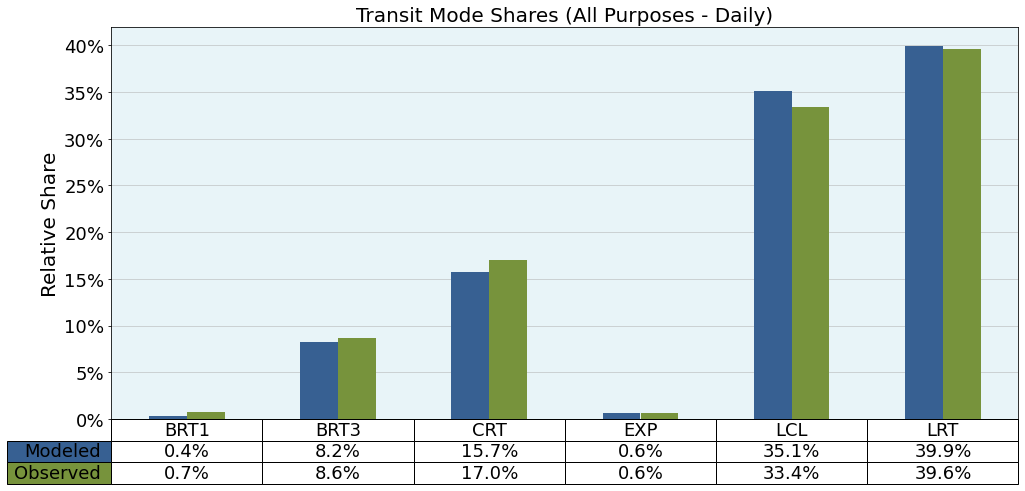

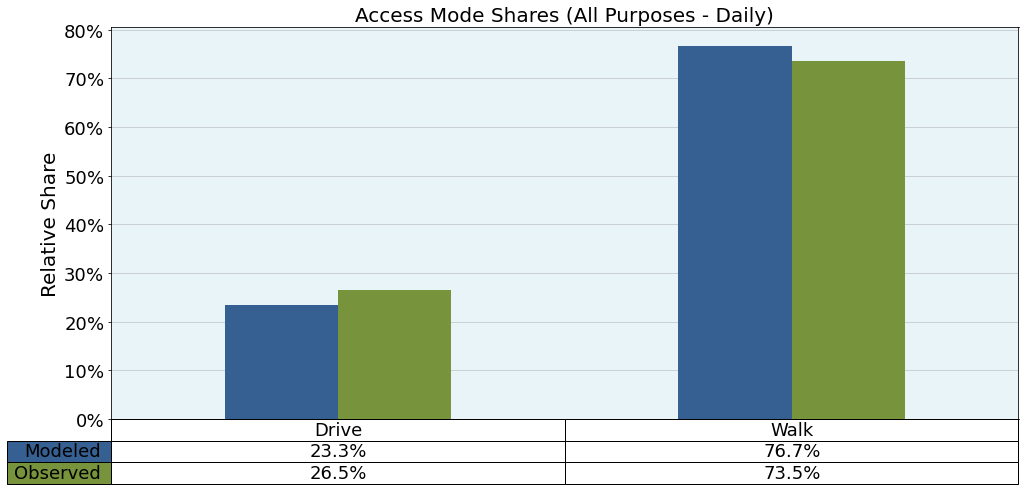

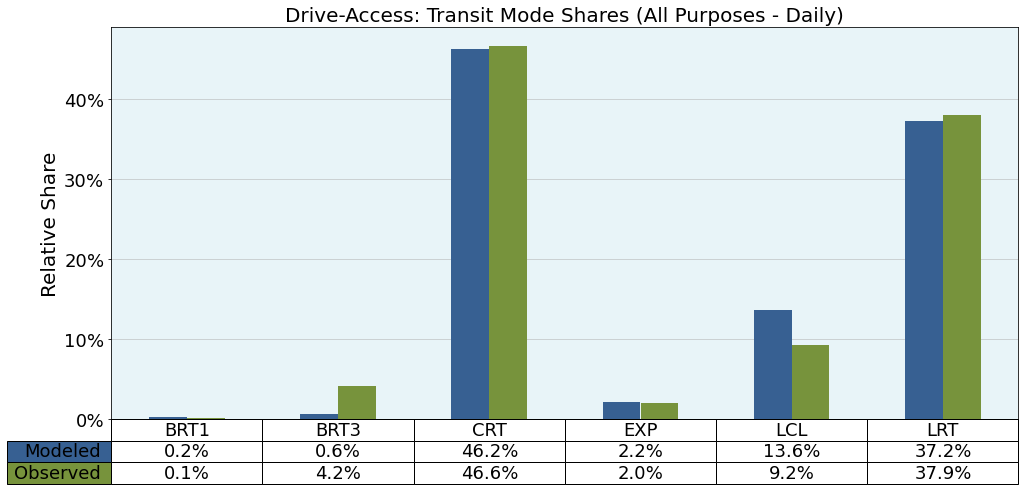

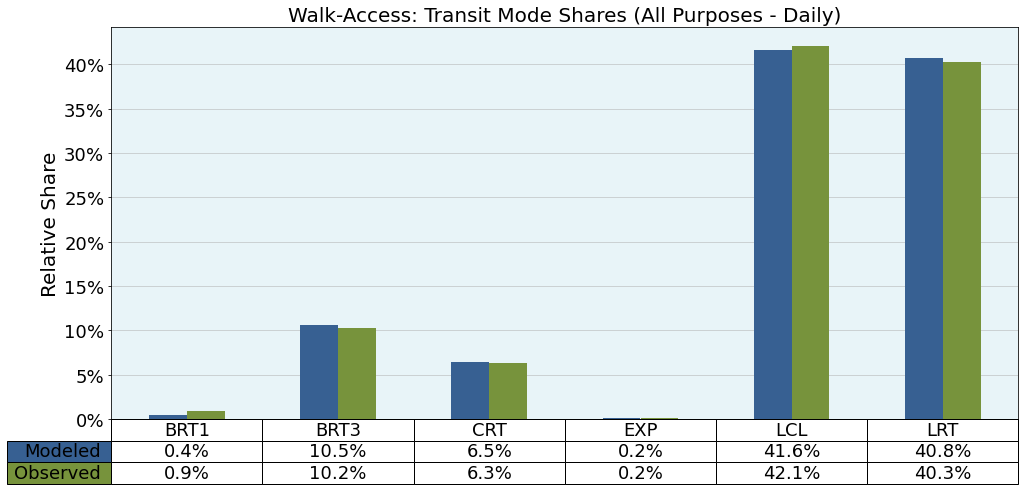

In [129]:
#filters use '$' for all

#global filters
filterPurp   = '$';   # Trip Purpose Filter Options: $-all, HBC, HBO, HBW, NHB
filterPeriod = '$';   # Period Filter Options: $-all, PK-peak, OK-Off-peak

#uncomment the one you want to use 
groupbyFields = [''];               # No grouping
#groupbyFields = [namePurp];         # Group by Trip Purpose
#groupbyFields = [namePeriod];         # Group by Period (pk/ok)
#groupbyFields = [namePurp,namePeriod]; # Group by Trip Purpose and by Period (pk/ok)

#group definition arrays
aFilterModeAc = []
aShareFields = []

dblHighlightThreshold = .10

#MAIN GROUPINGS

#non-motorized
aShareFields.append(nameModeMotor)
aFilterModeAc.append('$')

#auto/transit
aShareFields.append(nameModeAutoTransit)
aFilterModeAc.append('$')

#drive alone / shared
aShareFields.append(nameModeDAShare)
aFilterModeAc.append('$')

#drive alone / shared
aShareFields.append(nameModeShare23)
aFilterModeAc.append('$')

#shared
aShareFields.append(nameModeTransit)
aFilterModeAc.append('$')

#access mode
aShareFields.append(nameModeAccess)
aFilterModeAc.append('$')

#drive-access mode
aShareFields.append(nameModeTransit)
aFilterModeAc.append('Drive')

#walk-access mode
aShareFields.append(nameModeTransit)
aFilterModeAc.append('Walk')

#apply filters
df_COMPf = df_COMP
df_COMPf = df_COMPf.loc[(df_COMPf[namePurp].str.contains(filterPurp))]
df_COMPf = df_COMPf.loc[(df_COMPf[namePeriod].str.contains(filterPeriod))]

#Add dummy column for grouping if no grouping defined
strNoGrp = 'NoGroups'
if (groupbyFields == ['']):
    df_COMPf[strNoGrp] = strNoGrp
    groupbyFields = [strNoGrp]

strTotalField = ""
strTotal = "z--Total--z"
    
#Display filter information
print('\n')
display(Markdown('# Model/Observed Transit Shares Comparsion'))

#initialize dataframe collections
df_COMPfs = []
df_COMPfs_grp = []
df_COMPfs_grp_joined = []

#loop through main groupings
for x in range(len(aFilterModeAc)):
    
    #filter out nan values
    df_COMPfx = df_COMPf[df_COMPf[aShareFields[x]] != ''].copy()
    
    #apply Access Mode filter
    df_COMPfx = df_COMPfx.loc[(df_COMPfx[nameModeAccess].str.contains(aFilterModeAc[x]))].copy()
    
    #add filtered dataset to collection
    df_COMPfs.append(df_COMPfx)
    
    #aggregate by groupbyFields
    df_COMPfx_grp = df_COMPfx.groupby(groupbyFields, as_index=False).agg({nameTripsMod: [np.sum], nameTripsObs: [np.sum]})

    #drop the second header row to allow ease of calcs
    df_COMPfx_grp.columns = df_COMPfx_grp.columns.droplevel(1)
    
    #rename columns
    df_COMPfx_grp = df_COMPfx_grp.rename(columns={nameTripsObs:"g"+nameTripsObs,nameTripsMod:"g"+nameTripsMod})
    
    #add grouped dataset to collection
    df_COMPfs_grp.append(df_COMPfx_grp)

    #create new grouping by making copy and adding access
    shareFields = groupbyFields.copy()
    shareFields.append(aShareFields[x])

    #aggregate by shareFields
    df_COMPfx_grp_share = df_COMPfx.groupby(shareFields, as_index=False).agg({nameTripsMod: [np.sum], nameTripsObs: [np.sum]})

    #drop the second header row to allow ease of calcs
    df_COMPfx_grp_share.columns = df_COMPfx_grp_share.columns.droplevel(1)

    #join share data back to grouped data
    df_COMPfx_grp_joined = pd.DataFrame.merge(df_COMPfx_grp_share, df_COMPfx_grp, on=groupbyFields)

    #calcuate shares
    df_COMPfx_grp_joined[nameShareMod] = df_COMPfx_grp_joined[nameTripsMod] / df_COMPfx_grp_joined["g"+nameTripsMod]
    df_COMPfx_grp_joined[nameShareObs] = df_COMPfx_grp_joined[nameTripsObs] / df_COMPfx_grp_joined["g"+nameTripsObs]
    df_COMPfx_grp_joined = df_COMPfx_grp_joined.drop(columns=["g"+nameTripsMod,"g"+nameTripsObs])
    
    df_COMPfx_grp_joined[nameShareDiff] = df_COMPfx_grp_joined[nameShareMod] - df_COMPfx_grp_joined[nameShareObs]
    
    #add to collection df_COMPfx_grp_joined
    df_COMPfs_grp_joined.append(df_COMPfx_grp_joined)
    
    #calculate group subtotals
    df_COMPfx_grp_joined_totals = df_COMPfx_grp_joined.groupby(groupbyFields, as_index=False).agg({nameTripsMod:[np.sum],nameTripsObs:[np.sum],nameShareMod:[np.sum],nameShareObs:[np.sum],nameShareDiff:[np.sum]})
    
    #add column with z--Total--z descripion, uses z so it always sorts last
    df_COMPfx_grp_joined_totals[aShareFields[x]] = strTotal

    #drop the second level "sum" of multi-index
    df_COMPfx_grp_joined_totals.columns = df_COMPfx_grp_joined_totals.columns.droplevel(1)
    
    #append totals to joined dataset
    df_COMPfx_grp_joined_withtotals = df_COMPfx_grp_joined.append(df_COMPfx_grp_joined_totals,ignore_index=True)
    
    #redo sort so totals are sorted with gruoped data
    df_COMPfx_grp_joined_withtotals = df_COMPfx_grp_joined_withtotals.sort_values(by=shareFields)
    
    
    #display Table Title and access mode filter
    if (groupbyFields != [strNoGrp]):
        strTitleBy = " by " + ', '.join(groupbyFields).replace(strNoGrp,"")
    else:
        strTitleBy = ""
        df_COMPfx_grp_joined_withtotals = df_COMPfx_grp_joined_withtotals.drop(columns=strNoGrp)
    
    display (Markdown('***'))
    
    if (aFilterModeAc[x] != "$"):
        display (Markdown('## ' + aFilterModeAc[x] + ' Access: ' + aShareFields[x] + " Shares" + strTitleBy))
    else:
        display (Markdown('## ' + aShareFields[x] + " Shares" + strTitleBy))

    display(Markdown("Purpose: " + filterPurp.replace("$","All") + "; Period: " + filterPeriod.replace("$","All")))

    def highlight(s):        
        if s[aShareFields[x]] == strTotal:
            return ['background-color: grey; color: white; font-weight: bold']*len(s)
        elif abs(s[nameShareDiff])>=dblHighlightThreshold:
            return ['color: red; font-weight: bold']*len(s)
        else:
            return ['']*len(s)

    #print dataframe
    display(df_COMPfx_grp_joined_withtotals
            .style
            .format({nameTripsMod: "{:,.0f}".format, nameTripsObs:"{:,.0f}".format, nameShareMod: "{:,.1%}".format, nameShareObs: "{:,.1%}".format, nameShareDiff: "{:,.1%}".format})
            .apply(highlight, axis=1)
            )


display (Markdown('***'))
    
#Make Charts


sLegend1 = "Modeled"
sLegend2 = "Observed"

sColor1 = "#376092"
sColor2 = "#77933c"

sBGColor = "#e8f4f8"

sTitle = "Daily Boardings"

aFigureSize = (18,8)
iTitleSize = 20
iLegendSize = 12
iAxisItemSize = 18
iAxisTitleSize = 20


#loop through main groupings
for x in range(len(aFilterModeAc)):

    df_plot = df_COMPfs_grp_joined[x].copy()

    aNameColumns = []
    aNameIndex = []
    
    if (groupbyFields != [strNoGrp]):
        aNameIndex = groupbyFields.copy()
        aNameColumns= groupbyFields.copy()
    aNameIndex.append(aShareFields[x])    
    
    aNameColumns.append(aShareFields[x])
    aNameColumns.append(nameShareMod)
    aNameColumns.append(nameShareObs)
    
    sXAxisLabel = ""
    sYAxisLabel = "Relative Share"

    #sTitle =  sYAxisLabel

    aNameIndex.reverse()
    
    #df_plot = df_plot[[nameIndex,nameSeries1,nameSeries2]].set_index(nameIndex)
    df_plot = df_plot[aNameColumns].set_index(aNameIndex)
    
    df_plot = df_plot.sort_index()
    
    ax = df_plot.plot.bar(figsize=aFigureSize, fontsize=iAxisItemSize, color=(sColor1, sColor2), zorder=10)

    #set x,y labels
    ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
    ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)
    
    #display Table Title and access mode filter
    if (groupbyFields != [strNoGrp]):
        strTitleBy = " by " + ', '.join(groupbyFields).replace(strNoGrp,"")
    else:
        strTitleBy = ""
        #already dropped
        #df_COMPfx_grp_joined_withtotals = df_COMPfx_grp_joined_withtotals.drop(columns=strNoGrp)

    sTitle = aShareFields[x] + " Shares" + strTitleBy
    if (aFilterModeAc[x] != "$"):
        sTitle = aFilterModeAc[x] + '-Access: ' + sTitle
    
    sTitle = sTitle + " (" + filterPurp.replace("$","All Purposes") + " - " + filterPeriod.replace("$","Daily") + ")"
    
    #set title
    ax.set_title(sTitle, fontsize=iTitleSize)
    #add title 
    #display(Markdown("# " + sTitle))

    ax.legend([sLegend1,sLegend2], prop=dict(size=iLegendSize));

    ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))

    #ax.set_ylim([0, .5])

    ax.set_facecolor (sBGColor)

    # Add a table at the bottom of the axes

    #remove legend
    ax.get_legend().remove()

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.xticks([]) #remove x tick labels

    #setup table values, use T to transpose dataframe
    df_table = df_plot.copy()
    df_table[nameShareMod] = df_table[nameShareMod].astype(float).map("{:.1%}".format)
    df_table[nameShareObs] = df_table[nameShareObs].astype(float).map("{:.1%}".format)
    df_table = df_table[[nameShareMod,nameShareObs]].T
    cellValues = df_table.values.tolist()

    if (len(df_plot.index.names) >1):
        columnLabels = ['-'.join(col).strip() for col in df_plot.T.columns.values]
    else:
        columnLabels = df_plot.T.columns
    
    #create table and define attributes
    the_table = plt.table(cellText=cellValues,
                          rowLabels=[sLegend1,sLegend2],
                          rowColours=[sColor1,sColor2],
                          colLabels=columnLabels,
                          rowLoc='right',
                          cellLoc='center',
                          loc='bottom')
    the_table.set_fontsize(iAxisItemSize)
    the_table.scale(1,1.8)


# BOARDINGS

## TDM Boardings

In [130]:
dModeTDM = {
     'MODE_TDM': [4          ,5      ,6            ,7           ,8              ,9],
     'MODECODE': ['LCL'      ,'BRT1' ,'EXP'        ,'LRT'       ,'CRT'          ,'BRT3']#,
     #'MODENAME': ['Local BUS','BRT I','Express Bus','Light Rail','Commuter Rail','BRT III']
}
df_ModeTDM = pd.DataFrame(dModeTDM)
df_ModeTDM

,MODE_TDM,MODECODE
0,4,LCL
1,5,BRT1
2,6,EXP
3,7,LRT
4,8,CRT
5,9,BRT3


In [131]:
#define variables

dbf_TDM_PARoute = os.path.join(dirTDM, r'_v832_SE19_Net19_1_PA_Route.dbf')

csv_TDM_PARoute = os.path.join(dirData, r'TDM_PARoute.csv')

# Create function that converts dbfs to csvs using arcpy
def dbfToCSV(dbf, csv):
    TableToTable_conversion(dbf, os.path.dirname(csv), os.path.basename(csv))

# Allow arcpy to overwrite output files
env.overwriteOutput = True

# convert dbfs to csvs
dbfToCSV(dbf_TDM_PARoute, csv_TDM_PARoute)

dbf_TDM_PARoute = pd.read_csv(csv_TDM_PARoute)

In [132]:
dbf_TDM_PARoute

,OID_,MODE,NAMEID,NAME,OPERATOR,DIST,PK_HEADWAY,OK_HEADWAY,PK_TIME,OK_TIME,...,DY_D8_BRDA,DY_W8_BRDA,DY_8_XITB,DY_D9_BRDA,DY_W9_BRDA,DY_9_XITB,DY_D_BRDA,DY_W_BRDA,DY_BRDA,DY_XITB
0,NaN,4,1.000000,D460,0.0,24.400000,60,0,89.379997,81.610001,...,1.360000,2.840000,4.200000,0.000000,0.000000,0.000000,59.759998,90.540001,150.300003,150.300003
1,NaN,4,2.000000,D461,0.0,38.740002,30,0,136.070007,127.680000,...,14.310000,20.010000,34.320000,0.000000,0.000000,0.000000,19.490000,191.309998,210.800003,210.800003
2,NaN,4,3.000000,D462,0.0,23.440001,40,0,82.650002,74.620003,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,94.809998,95.459999,95.459999
3,NaN,4,4.000000,FD605,0.0,7.980000,30,30,27.740000,28.070000,...,18.580000,26.430000,45.009998,0.000000,0.000000,0.000000,21.170000,118.349999,139.520004,139.520004
4,NaN,4,4.100000,FD605-,0.0,7.980000,30,30,28.010000,28.070000,...,0.000000,5.620000,5.620000,0.000000,0.000000,0.000000,2.850000,83.790001,86.639999,86.639999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,NaN,7,107.099999,Sline-,0.0,2.140000,15,15,11.140000,11.140000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.830000,214.529999,229.360001,229.360001
172,NaN,8,108.000000,RCRT_OGPN,0.0,81.099998,30,60,123.000000,123.000000,...,3624.850098,2019.199951,5644.049805,0.000000,0.000000,0.000000,3624.850098,2019.199951,5644.049805,5644.049805
173,NaN,8,108.099999,RCRT_OGPN-,0.0,81.099998,30,60,116.550003,116.550003,...,8195.639648,3424.929932,11620.570312,0.000000,0.000000,0.000000,8195.639648,3424.929932,11620.570312,11620.570312
174,NaN,9,109.000000,BRT_ProOrm,0.0,11.460000,6,10,41.400002,41.119999,...,277.239990,79.639999,356.880005,97.980003,5180.120117,5278.100098,375.220001,5259.759766,5634.979981,5634.979981


In [133]:
dbf_TDM_PARoute_LinkModebyBoardMode = pd.melt(dbf_TDM_PARoute, id_vars=['MODE','NAMEID','NAME'], value_vars=['DY_4_XITB','DY_5_XITB','DY_6_XITB','DY_7_XITB','DY_8_XITB','DY_9_XITB'])
#dbf_TDM_PARoute_melt.columns = (namePeriod,'TripCategory',namePurp,'Trips_TDM')

dbf_TDM_PARoute_LinkModebyBoardMode[nameModeTransit+'_modeTDM'] = pd.to_numeric(dbf_TDM_PARoute_LinkModebyBoardMode['variable'].str.get(3))
dbf_TDM_PARoute_LinkModebyBoardMode

,MODE,NAMEID,NAME,variable,value,Transit Mode_modeTDM
0,4,1.000000,D460,DY_4_XITB,129.740005,4
1,4,2.000000,D461,DY_4_XITB,151.009995,4
2,4,3.000000,D462,DY_4_XITB,71.500000,4
3,4,4.000000,FD605,DY_4_XITB,94.510002,4
4,4,4.100000,FD605-,DY_4_XITB,81.019997,4
...,...,...,...,...,...,...
1051,7,107.099999,Sline-,DY_9_XITB,0.000000,9
1052,8,108.000000,RCRT_OGPN,DY_9_XITB,0.000000,9
1053,8,108.099999,RCRT_OGPN-,DY_9_XITB,0.000000,9
1054,9,109.000000,BRT_ProOrm,DY_9_XITB,5278.100098,9


In [134]:
df_TDM_Boardings = dbf_TDM_PARoute_LinkModebyBoardMode.groupby(['MODE',nameModeTransit+'_modeTDM'],as_index=False).agg({'value': [np.sum]})

df_TDM_Boardings.columns = ([nameModeBoard+'_modeTDM',nameModeTransit+'_modeTDM',nameBoardTDM])

df_TDM_Boardings

,Transit Mode - Surveyed_modeTDM,Transit Mode_modeTDM,Boardings_TDM
0,4,4,40027.530007
1,4,5,142.869998
2,4,6,24.430000
3,4,7,9957.199998
4,4,8,10783.380091
5,4,9,848.620008
6,5,4,0.000000
7,5,5,408.709991
8,5,6,0.000000
9,5,7,701.710007


In [135]:
df_TDM_Boardings.dtypes

Transit Mode - Surveyed_modeTDM      int64
Transit Mode_modeTDM                 int64
Boardings_TDM                      float64
dtype: object

In [136]:
df_TDM_Boardings = pd.DataFrame.merge(df_ModeTDM, df_TDM_Boardings, left_on='MODE_TDM', right_on=nameModeBoard+'_modeTDM')
df_TDM_Boardings = df_TDM_Boardings.drop(columns=['MODE_TDM',nameModeBoard+'_modeTDM'])
df_TDM_Boardings = df_TDM_Boardings.rename(columns={'MODECODE':nameModeBoard})
df_TDM_Boardings

,Transit Mode - Surveyed,Transit Mode_modeTDM,Boardings_TDM
0,LCL,4,40027.530007
1,LCL,5,142.869998
2,LCL,6,24.430000
3,LCL,7,9957.199998
4,LCL,8,10783.380091
5,LCL,9,848.620008
6,BRT1,4,0.000000
7,BRT1,5,408.709991
8,BRT1,6,0.000000
9,BRT1,7,701.710007


In [137]:
df_TDM_Boardings = pd.DataFrame.merge(df_ModeTDM, df_TDM_Boardings, left_on='MODE_TDM', right_on=nameModeTransit+'_modeTDM')
df_TDM_Boardings = df_TDM_Boardings.drop(columns=['MODE_TDM',nameModeTransit+'_modeTDM'])
df_TDM_Boardings = df_TDM_Boardings.rename(columns={'MODECODE':nameModeTransit})
df_TDM_Boardings

,Transit Mode,Transit Mode - Surveyed,Boardings_TDM
0,LCL,LCL,40027.530007
1,LCL,BRT1,0.000000
2,LCL,EXP,0.000000
3,LCL,LRT,0.000000
4,LCL,CRT,0.000000
5,LCL,BRT3,0.000000
6,BRT1,LCL,142.869998
7,BRT1,BRT1,408.709991
8,BRT1,EXP,0.000000
9,BRT1,LRT,0.000000


In [138]:
df_TDM_Boardings_BoardMode = df_TDM_Boardings.groupby([nameModeBoard], as_index=False).agg({nameBoardTDM: [np.sum]})

#drop the second header row
df_TDM_Boardings_BoardMode.columns = df_TDM_Boardings_BoardMode.columns.droplevel(1)

df_TDM_Boardings_BoardMode

,Transit Mode - Surveyed,Boardings_TDM
0,BRT1,1110.419998
1,BRT3,9669.189972
2,CRT,17264.620117
3,EXP,1345.470019
4,LCL,61784.030101
5,LRT,47139.460585


In [139]:
df_TDM_Boardings_TransitMode = df_TDM_Boardings.groupby([nameModeTransit], as_index=False).agg({nameBoardTDM: [np.sum]})

#drop the second header row
df_TDM_Boardings_TransitMode.columns = df_TDM_Boardings_TransitMode.columns.droplevel(1)

df_TDM_Boardings_TransitMode

,Transit Mode,Boardings_TDM
0,BRT1,551.579989
1,BRT3,9880.599988
2,CRT,30623.470214
3,EXP,717.020008
4,LCL,40027.530007
5,LRT,56512.990587


## TDM Trips

In [140]:
df_TDM_Trips = df_TDM.groupby(nameModeTransit, as_index=False).agg({nameTripsTDM: [np.sum]})

df_TDM_Trips = df_TDM_Trips[df_TDM_Trips[nameModeTransit] != '']

#drop the second header row to allow ease of calcs
df_TDM_Trips.columns = df_TDM_Trips.columns.droplevel(1)
df_TDM_Trips

,Transit Mode,Trips_TDM
1,BRT1,409
2,BRT3,9032
3,CRT,17265
4,EXP,687
5,LCL,38488
6,LRT,43795


## OBS Boardings

In [141]:
df_OBS

,ID_OBS,Vehicle Ownership,Trip Purpose,Access Mode,Transit Mode,Transit Mode - Surveyed,Period,Trips_OBS,Boardings_OBS
0,22.0,1.0,HBW,Walk,LRT,LRT,PK,0.78118,2.34353
1,24.0,0.0,NHB,Walk,LRT,LRT,PK,12.73294,12.73294
2,29.0,0.0,HBO,Walk,LRT,LRT,PK,3.79529,7.59058
3,30.0,2.0,HBO,Drive,CRT,LRT,PK,5.71992,11.43983
4,31.0,0.0,HBW,Walk,LRT,LRT,PK,6.67243,6.67243
...,...,...,...,...,...,...,...,...,...
13412,22742.0,0.0,HBW,Walk,LRT,LRT,PK,4.49303,4.49303
13413,22743.0,0.0,HBW,Walk,LRT,LRT,PK,5.50734,11.01468
13414,22744.0,1.0,HBW,Drive,CRT,CRT,OK,4.47037,4.47037
13415,22745.0,1.0,HBW,Walk,CRT,CRT,PK,5.97575,11.95150


In [142]:
df_OBS_Boardings_Trips = df_OBS.groupby(nameModeTransit, as_index=False).agg({nameBoardOBS: [np.sum], nameTripsOBS: [np.sum]})

#drop the second header row to allow ease of calcs
df_OBS_Boardings_Trips.columns = df_OBS_Boardings_Trips.columns.droplevel(1)

df_OBS_Boardings_Trips

,Transit Mode,Boardings_OBS,Trips_OBS
0,BRT1,1001.18412,785.53044
1,BRT3,10367.88721,9414.77912
2,CRT,30636.14754,18502.12614
3,EXP,731.20101,696.17688
4,LCL,42291.11016,36385.03276
5,LRT,58430.04149,43216.20955


In [143]:
df_OBS_Boardings_BoardMode = df_OBS.groupby(nameModeBoard, as_index=False).agg({nameBoardOBS: [np.sum]})

#drop the second header row to allow ease of calcs
df_OBS_Boardings_BoardMode.columns = df_OBS_Boardings_BoardMode.columns.droplevel(1)

df_OBS_Boardings_BoardMode

,Transit Mode - Surveyed,Boardings_OBS
0,BRT1,1504.81489
1,BRT3,11492.41332
2,CRT,18606.60544
3,EXP,953.60498
4,LCL,57283.93236
5,LRT,53616.20054


## Trips

## Trips

,Trips-Model,Trips-Observed,Diff,% Diff
Transit Mode,,,,
BRT1,409,786,-377,-47.9%
BRT3,"9,032","9,415",-383,-4.1%
CRT,"17,265","18,502","-1,237",-6.7%
EXP,687,696,-9,-1.3%
LCL,"38,488","36,385","2,103",5.8%
LRT,"43,795","43,216",579,1.3%
Total,"109,676","109,000",676,0.6%


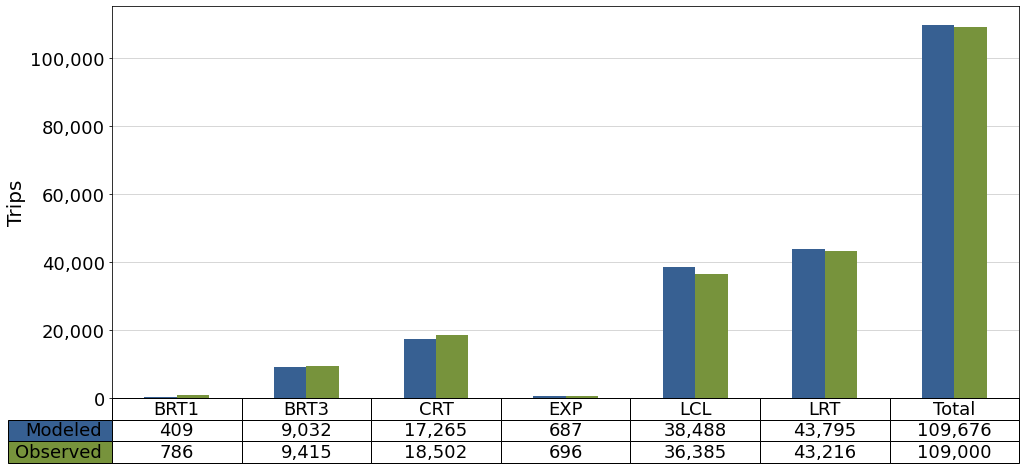

In [144]:
df_Trips = pd.DataFrame.merge(df_TDM_Trips, df_OBS_Boardings_Trips[[nameModeTransit,nameTripsOBS]], on=nameModeTransit, how='outer')
df_Trips.columns = (nameModeTransit, nameTripsMod, nameTripsObs)

df_Trips = df_Trips.set_index(nameModeTransit)

#add total row
df_Trips = df_Trips.append(df_Trips.sum(numeric_only=True).rename('Total'))

#calculate difference
df_Trips['Diff'] = df_Trips[nameTripsMod] - df_Trips[nameTripsObs]
df_Trips['% Diff'] = df_Trips['Diff'] / df_Trips[nameTripsObs]

display (Markdown('## ' + "Trips" + strTitleBy))

#print dataframe
display(df_Trips
        .style
        .format({nameTripsMod: "{:,.0f}".format, nameTripsObs:"{:,.0f}".format, 'Diff': "{:,.0f}".format, '% Diff': "{:,.1%}".format})
        )


sXAxisLabel = ""
sYAxisLabel = "Trips"

#sTitle =  sYAxisLabel


df_plot = df_Trips[[nameTripsMod,nameTripsObs]].copy()

ax = df_plot.plot.bar(figsize=aFigureSize, fontsize=iAxisItemSize, color=(sColor1, sColor2), zorder=10)

#set x,y labels
ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

ax.legend([sLegend1,sLegend2], prop=dict(size=iLegendSize));

ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

#ax.set_ylim([0, .5])

# Add a table at the bottom of the axes

#remove legend
ax.get_legend().remove()

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xticks([]) #remove x tick labels

#setup table values, use T to transpose dataframe
df_table = df_plot.copy()
df_table[nameTripsMod] = df_table[nameTripsMod].astype(float).map("{:,.0f}".format)
df_table[nameTripsObs] = df_table[nameTripsObs].astype(float).map("{:,.0f}".format)
df_table = df_table[[nameTripsMod,nameTripsObs]].T
cellValues = df_table.values.tolist()
columnLabels = df_plot.T.columns

#create table and define attributes
the_table = plt.table(cellText=cellValues,
                      rowLabels=[sLegend1,sLegend2],
                      rowColours=[sColor1,sColor2],
                      colLabels=columnLabels,
                      rowLoc='right',
                      cellLoc='center',
                      loc='bottom')
the_table.set_fontsize(iAxisItemSize)
the_table.scale(1,1.8)

## Boardings by Linked Trips

## Boardings by Linked Trips

,Boardings-Model,Boardings-Observed,Diff,% Diff
Transit Mode,,,,
BRT1,552,"1,001",-450,-44.9%
BRT3,"9,881","10,368",-487,-4.7%
CRT,"30,623","30,636",-13,-0.0%
EXP,717,731,-14,-1.9%
LCL,"40,028","42,291","-2,264",-5.4%
LRT,"56,513","58,430","-1,917",-3.3%
Total,"138,313","143,458","-5,144",-3.6%


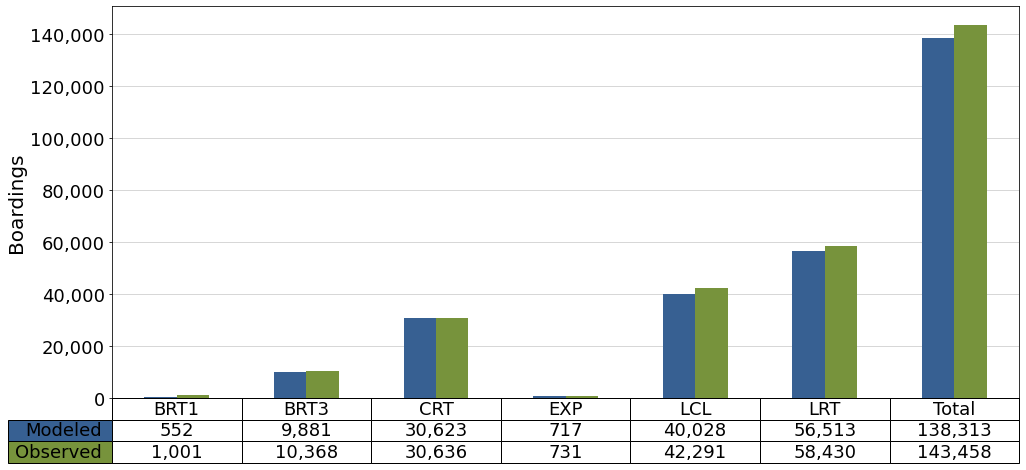

In [145]:
df_Boardings_LinkedTrip = pd.DataFrame.merge(df_TDM_Boardings_TransitMode, df_OBS_Boardings_Trips[[nameModeTransit,nameBoardOBS]], on=nameModeTransit, how='outer')
df_Boardings_LinkedTrip.columns = (nameModeTransit, nameBoardMod, nameBoardObs)

df_Boardings_LinkedTrip = df_Boardings_LinkedTrip.set_index(nameModeTransit)

#add total row
df_Boardings_LinkedTrip = df_Boardings_LinkedTrip.append(df_Boardings_LinkedTrip.sum(numeric_only=True).rename('Total'))

#calculate difference
df_Boardings_LinkedTrip['Diff'] = df_Boardings_LinkedTrip[nameBoardMod] - df_Boardings_LinkedTrip[nameBoardObs]
df_Boardings_LinkedTrip['% Diff'] = df_Boardings_LinkedTrip['Diff'] / df_Boardings_LinkedTrip[nameBoardObs]

display (Markdown('## ' + "Boardings by Linked Trips" + strTitleBy))

#print dataframe
display(df_Boardings_LinkedTrip
        .style
        .format({nameBoardMod: "{:,.0f}".format, nameBoardObs:"{:,.0f}".format, 'Diff': "{:,.0f}".format, '% Diff': "{:,.1%}".format})
        )


sXAxisLabel = ""
sYAxisLabel = "Boardings"

#sTitle =  sYAxisLabel


df_plot = df_Boardings_LinkedTrip[[nameBoardMod,nameBoardObs]].copy()

ax = df_plot.plot.bar(figsize=aFigureSize, fontsize=iAxisItemSize, color=(sColor1, sColor2), zorder=10)

#set x,y labels
ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

ax.legend([sLegend1,sLegend2], prop=dict(size=iLegendSize));

ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

#ax.set_ylim([0, .5])

# Add a table at the bottom of the axes

#remove legend
ax.get_legend().remove()

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xticks([]) #remove x tick labels

#setup table values, use T to transpose dataframe
df_table = df_plot.copy()
df_table[nameBoardMod] = df_table[nameBoardMod].astype(float).map("{:,.0f}".format)
df_table[nameBoardObs] = df_table[nameBoardObs].astype(float).map("{:,.0f}".format)
df_table = df_table[[nameBoardMod,nameBoardObs]].T
cellValues = df_table.values.tolist()
columnLabels = df_plot.T.columns

#create table and define attributes
the_table = plt.table(cellText=cellValues,
                      rowLabels=[sLegend1,sLegend2],
                      rowColours=[sColor1,sColor2],
                      colLabels=columnLabels,
                      rowLoc='right',
                      cellLoc='center',
                      loc='bottom')
the_table.set_fontsize(iAxisItemSize)
the_table.scale(1,1.8)

## Transfer Ratio

## Transfer Ratio

,Transfer Ratio-Model,Transfer Ratio-Observed,Diff,% Diff
Transit Mode,,,,
BRT1,1.35,1.27,0.07,5.8%
BRT3,1.09,1.10,-0.01,-0.7%
CRT,1.77,1.66,0.12,7.1%
EXP,1.04,1.05,-0.01,-0.6%
LCL,1.04,1.16,-0.12,-10.5%
LRT,1.29,1.35,-0.06,-4.6%
Total,1.26,1.32,-0.06,-4.2%


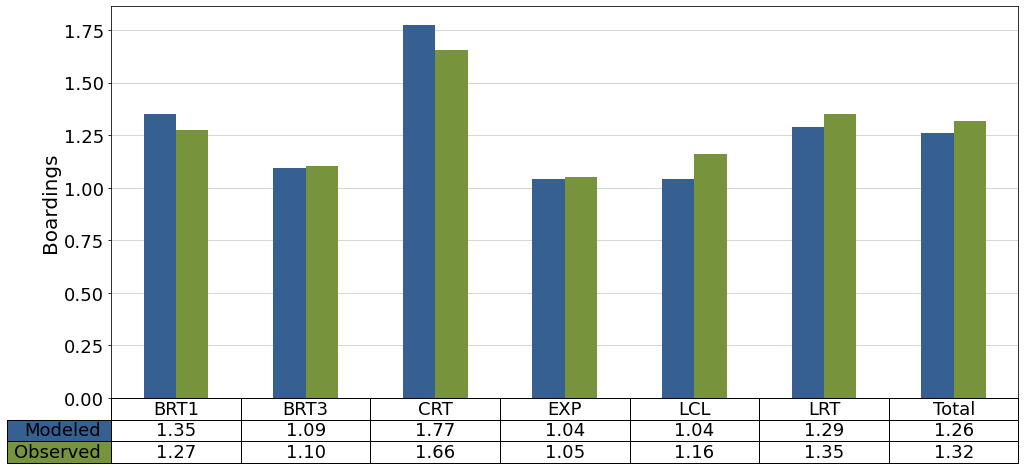

In [146]:
df_TxRatio = pd.DataFrame.merge(df_Trips[[nameTripsMod, nameTripsObs]], df_Boardings_LinkedTrip[[nameBoardMod, nameBoardObs]], on=nameModeTransit, how='outer')
#df_Trips.columns = (nameModeTransit, nameBoardMod, nameBoardObs)

#df_TxRatio = df_TxRatio.set_index(nameModeTransit)

#calculate transfer ratio
df_TxRatio[nameTxRatioMod] = df_TxRatio[nameBoardMod] / df_TxRatio[nameTripsMod]
df_TxRatio[nameTxRatioObs] = df_TxRatio[nameBoardObs] / df_TxRatio[nameTripsObs]

#calculate difference
df_TxRatio['Diff'] = df_TxRatio[nameTxRatioMod] - df_TxRatio[nameTxRatioObs]
df_TxRatio['% Diff'] = df_TxRatio['Diff'] / df_TxRatio[nameTxRatioObs]

display (Markdown('## ' + "Transfer Ratio" + strTitleBy))

#print dataframe
display(df_TxRatio[[nameTxRatioMod, nameTxRatioObs, 'Diff', '% Diff']]
        .style
        .format({nameTxRatioMod: "{:,.2f}".format, nameTxRatioObs:"{:,.2f}".format, 'Diff': "{:,.2f}".format, '% Diff': "{:,.1%}".format})
        )


sXAxisLabel = ""
sYAxisLabel = "Boardings"

#sTitle =  sYAxisLabel


df_plot = df_TxRatio[[nameTxRatioMod,nameTxRatioObs]].copy()

ax = df_plot.plot.bar(figsize=aFigureSize, fontsize=iAxisItemSize, color=(sColor1, sColor2), zorder=10)

#set x,y labels
ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

ax.legend([sLegend1,sLegend2], prop=dict(size=iLegendSize));

ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.2f}'))

#ax.set_ylim([0, .5])

# Add a table at the bottom of the axes

#remove legend
ax.get_legend().remove()

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xticks([]) #remove x tick labels

#setup table values, use T to transpose dataframe
df_table = df_plot.copy()
df_table[nameTxRatioMod] = df_table[nameTxRatioMod].astype(float).map("{:,.2f}".format)
df_table[nameTxRatioObs] = df_table[nameTxRatioObs].astype(float).map("{:,.2f}".format)
df_table = df_table[[nameTxRatioMod,nameTxRatioObs]].T
cellValues = df_table.values.tolist()
columnLabels = df_plot.T.columns

#create table and define attributes
the_table = plt.table(cellText=cellValues,
                      rowLabels=[sLegend1,sLegend2],
                      rowColours=[sColor1,sColor2],
                      colLabels=columnLabels,
                      rowLoc='right',
                      cellLoc='center',
                      loc='bottom')
the_table.set_fontsize(iAxisItemSize)
the_table.scale(1,1.8)

## Boardings by Mode Surveyed

## Boardings by Mode Surveyed Trips

,Boardings-Model,Boardings-Observed,Diff,% Diff
Transit Mode - Surveyed,,,,
BRT1,"1,110","1,505",-394,-26.2%
BRT3,"9,669","11,492","-1,823",-15.9%
CRT,"17,265","18,607","-1,342",-7.2%
EXP,"1,345",954,392,41.1%
LCL,"61,784","57,284","4,500",7.9%
LRT,"47,139","53,616","-6,477",-12.1%
Total,"138,313","143,458","-5,144",-3.6%


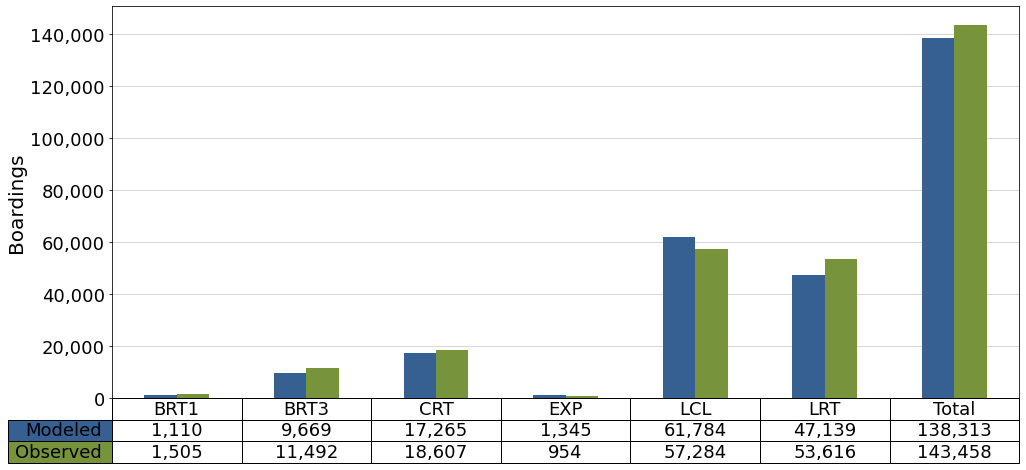

In [147]:
df_Boardings_ModeSurveyed = pd.DataFrame.merge(df_TDM_Boardings_BoardMode, df_OBS_Boardings_BoardMode[[nameModeBoard,nameBoardOBS]], on=nameModeBoard, how='outer')
df_Boardings_ModeSurveyed.columns = (nameModeBoard, nameBoardMod, nameBoardObs)

df_Boardings_ModeSurveyed = df_Boardings_ModeSurveyed.set_index(nameModeBoard)

#add total row
df_Boardings_ModeSurveyed = df_Boardings_ModeSurveyed.append(df_Boardings_ModeSurveyed.sum(numeric_only=True).rename('Total'))

#calculate difference
df_Boardings_ModeSurveyed['Diff'] = df_Boardings_ModeSurveyed[nameBoardMod] - df_Boardings_ModeSurveyed[nameBoardObs]
df_Boardings_ModeSurveyed['% Diff'] = df_Boardings_ModeSurveyed['Diff'] / df_Boardings_ModeSurveyed[nameBoardObs]

display (Markdown('## ' + "Boardings by Mode Surveyed Trips" + strTitleBy))

#print dataframe
display(df_Boardings_ModeSurveyed
        .style
        .format({nameBoardMod: "{:,.0f}".format, nameBoardObs:"{:,.0f}".format, 'Diff': "{:,.0f}".format, '% Diff': "{:,.1%}".format})
        )


sXAxisLabel = ""
sYAxisLabel = "Boardings"

#sTitle =  sYAxisLabel


df_plot = df_Boardings_ModeSurveyed[[nameBoardMod,nameBoardObs]].copy()

ax = df_plot.plot.bar(figsize=aFigureSize, fontsize=iAxisItemSize, color=(sColor1, sColor2), zorder=10)

#set x,y labels
ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

ax.legend([sLegend1,sLegend2], prop=dict(size=iLegendSize));

ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

#ax.set_ylim([0, .5])

# Add a table at the bottom of the axes

#remove legend
ax.get_legend().remove()

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xticks([]) #remove x tick labels

#setup table values, use T to transpose dataframe
df_table = df_plot.copy()
df_table[nameBoardMod] = df_table[nameBoardMod].astype(float).map("{:,.0f}".format)
df_table[nameBoardObs] = df_table[nameBoardObs].astype(float).map("{:,.0f}".format)
df_table = df_table[[nameBoardMod,nameBoardObs]].T
cellValues = df_table.values.tolist()
columnLabels = df_plot.T.columns

#create table and define attributes
the_table = plt.table(cellText=cellValues,
                      rowLabels=[sLegend1,sLegend2],
                      rowColours=[sColor1,sColor2],
                      colLabels=columnLabels,
                      rowLoc='right',
                      cellLoc='center',
                      loc='bottom')
the_table.set_fontsize(iAxisItemSize)
the_table.scale(1,1.8)